In [2]:
import os

import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from clickhouse_driver import Client

client = Client('localhost', database="thesisnumclientsdb")

In [3]:
%%time 

exp_data_sql = """
SELECT
	ex.*
FROM
	experiment ex
"""
exp_df = client.query_dataframe(exp_data_sql)
print(len(exp_df.exp_id.unique().tolist()))
print("\n".join(exp_df.exp_id.unique().tolist()))
print()
exp_df

16
thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_2clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_3clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_4clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_5clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_6clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_7clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_coap_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_dtls_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client
thesis_group_num_clients_dtls_https_2clients_noattacker__140sec_proxy__30sec_attacker__1

exp_id  \
0   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_num_clients_coap_https_2clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_num_clients_coap_https_3clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_num_clients_coap_https_4clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4   thesis_group_num_clients_coap_https_5clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
5   thesis_group_num_clients_coap_https_6clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
6   thesis_group_num_clients_coap_https_7clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
7   thesis_group_num_clients_coap_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
8   thesis_group_num_clients_dtls_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
9   thesis_group_num_clients_dtls_https_2clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
10  thesis_group_num_clients_dtls_https_3clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
11  thesis_group_num_clients_dtls_https_4clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
12  thesis_group_num_clients_dtls_https_5clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
13  thesis_group_num_clients_dtls_https_6clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
14  thesis_group_num_clients_dtls_https_7clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
15  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

   attacker_rate  server_connections  max_keep_alive_requests  num_clients  \
0          0mbps                 256                        0            1   
1          0mbps                 256                        0            2   
2          0mbps                 256                        0            3   
3          0mbps                 256                        0            4   
4          0mbps                 256                        0            5   
5          0mbps                 256                        0            6   
6          0mbps                 256                        0            7   
7          0mbps                 256                        0            8   
8          0mbps                 256                        0            1   
9          0mbps                 256                        0            2   
10         0mbps                 256                        0            3   
11         0mbps                 256                        0            4   
12         0mbps                 256                        0            5   
13         0mbps                 256                        0            6   
14         0mbps                 256                        0            7   
15         0mbps                 256                        0            8   

    num_trials  origin_server_duration  attacker_duration  receiver_duration  \
0            5                     140                 30                140   
1            5                     140                 30                140   
2            5                     140                 30                140   
3            5                     140                 30                140   
4            5                     140                 30                140   
5            5                     140                 30                140   
6            5                     140                 30                140   
7            5                     140                 30                140   
8            5                     140                 30                140   
9            5                     140                 30                140   
10           5                     140                

In [4]:
%%time 

fetch_metadata_sql = """
SELECT
	n.node_name,
	dn.dnid,
	dn.node_id,
  dn.exp_id
FROM 
	deployed_node dn
	JOIN node n ON n.node_id = dn.node_id
"""

metadata_df = client.query_dataframe(fetch_metadata_sql)

dnid_map_node_name = dict()
dnid_map_exp_id = dict()
node_id_map_node_name = dict()

for record in metadata_df.to_dict(orient="records"):
  dnid = record["dnid"]
  node_id = record["node_id"]
  node_name = record["node_name"]
  exp_id = record["exp_id"]
  
  assert dnid not in dnid_map_node_name
  dnid_map_node_name[dnid] = node_name
  dnid_map_exp_id[dnid] = exp_id
  
  if node_id in node_id_map_node_name:
    assert node_id_map_node_name[node_id] == node_name
  else:
    node_id_map_node_name[node_id] = node_name
  
client_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("client"))
attacker_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("attacker"))

client_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("client"))

print(f"{client_dnids=}")
print(f"{attacker_dnids=}")
print(f"{client_node_ids=}")

client_dnids={2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 91, 92, 93, 98, 99, 100, 101, 102, 103, 104, 105, 110, 111, 112, 113, 114, 115, 116, 117, 122, 123, 124, 125, 126, 127, 128, 129, 134, 135, 136, 137, 138, 139, 140, 141, 146, 147, 148, 149, 150, 151, 152, 153, 158, 159, 160, 161, 162, 163, 164, 165, 170, 171, 172, 173, 174, 175, 176, 177, 182, 183, 184, 185, 186, 187, 188, 189}
attacker_dnids={1, 97, 121, 37, 133, 73, 169, 13, 109, 49, 145, 85, 157, 181, 25, 61}
client_node_ids={2, 3, 4, 5, 6, 7, 8, 9}
CPU times: user 9.32 ms, sys: 0 ns, total: 9.32 ms
Wall time: 26.1 ms


In [5]:
client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  groupArray(client_recvs.response_code)[1] AS response_code,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  LEFT JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  exp_id, trial, observer_id, message_marker
ORDER BY
  exp_id, trial, observer_id, message_marker
"""

message_rtt_df = client.query_dataframe(client_messages_sql)
message_rtt_df.observer_id.replace(dnid_map_node_name, inplace=True)

message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

message_rtt_df = message_rtt_df.merge(exp_df, on="exp_id", how="left")

# Due to left join, we need to eliminate lines that
# have negative RTT, so we NaN them.
message_rtt_df.loc[
  (message_rtt_df["rtt_ms_first_transmission"] < 0)
  | (message_rtt_df["rtt_ms_last_transmission"] < 0)
  ,
  ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
] = np.nan

message_rtt_df

['content' '' 'bad_gateway']


exp_id  \
0       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                      ...   
797570  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
797571  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
797572  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
797573  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
797574  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

        trial observer_id  message_marker response_code  send_time_sec  \
0           1     client1               1       content       0.000000   
1           1     client1               2       content       0.355290   
2           1     client1               3       content       0.418002   
3           1     client1               4       content       0.479755   
4           1     client1               5       content       0.539208   
...       ...         ...             ...           ...            ...   
797570      5     client8           17773       content     125.717236   
797571      5     client8           17774       content     125.770620   
797572      5     client8           17775       content     125.823910   
797573      5     client8           17776       content     125.877252   
797574      5     client8           17777                   125.930663   

        recv_time_sec  first_send_time_sec  last_send_time_sec  \
0            0.340071             0.000000            0.000000   
1            0.415595             0.355290            0.355290   
2            0.477663             0.418002            0.418002   
3            0.536881             0.479755            0.479755   
4            0.595318             0.539208            0.539208   
...               ...                  ...                 ...   
797570     125.769829           125.717236          125.717236   
797571     125.823153           125.770620          125.770620   
797572     125.876400           125.823910          125.823910   
797573     125.929843           125.877252          125.877252   
797574       0.000000           125.930663          125.930663   

        first_recv_time_sec  ...                             topology_name  \
0                  0.340071  ...  thesis_cloud_proxy_and_internet_attacker   
1                  0.415595  ...  thesis_cloud_proxy_and_internet_attacker   
2                  0.477663  ...  thesis_cloud_proxy_and_internet_attacker   
3                  0.536881  ...  thesis_cloud_proxy_and_internet_attacker   
4                  0.595318  ...  thesis_cloud_proxy_and_internet_attacker   
...                     ...  ...                                       ...   
797570           125.769829  ...  thesis_cloud_proxy_and_internet_attacker   
797571           125.823153  ...  thesis_cloud_proxy_and_internet_attacker   
797572           125.876400  ...  thesis_cloud_proxy_and_internet_attacker   
797573           125.929843  ...  thesis_cloud_proxy_and_internet_attacker   
797574             0.000000  ...  thesis_cloud_proxy_and_internet_attacker   

        num_proxy_connections  request_timeout  max_retries  \
0                          50                5            2   
1           

In [6]:
%%time

client_sends_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
)

SELECT * FROM client_sends
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_sends_df = client.query_dataframe(client_sends_sql)
client_sends_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_sends_df

CPU times: user 1.44 s, sys: 223 ms, total: 1.66 s
Wall time: 2.19 s


exp_id  \
0       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                      ...   
797570  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
797571  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
797572  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
797573  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
797574  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

        observe_timestamp  trial observer_id  message_marker  \
0                0.000000      1     client1               1   
1                0.355290      1     client1               2   
2                0.418002      1     client1               3   
3                0.479755      1     client1               4   
4                0.539208      1     client1               5   
...                   ...    ...         ...             ...   
797570         125.717236      5     client8           17773   
797571         125.770620      5     client8           17774   
797572         125.823910      5     client8           17775   
797573         125.877252      5     client8           17776   
797574         125.930663      5     client8           17777   

        coap_retransmitted  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  
...                    ...  
797570               False  
797571               False  
797572               False  
797573               False  
797574               False  

[797575 rows x 6 columns]

In [7]:
%%time

client_recvs_sql = f"""
WITH client_recvs AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT * FROM client_recvs
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_recvs_df = client.query_dataframe(client_recvs_sql)
client_recvs_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_recvs_df["successful_message"] = False
client_recvs_df.loc[(client_recvs_df["response_code"] == "content"), "successful_message"] = True

print(client_recvs_df["response_code"].unique())

client_recvs_df

['content' 'bad_gateway']
CPU times: user 1.73 s, sys: 571 ms, total: 2.3 s
Wall time: 2.9 s


exp_id  \
0       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4       thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                      ...   
797218  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
797219  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
797220  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
797221  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
797222  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

        observe_timestamp  trial observer_id  message_marker response_code  \
0                0.340071      1     client1               1       content   
1                0.415595      1     client1               2       content   
2                0.477663      1     client1               3       content   
3                0.536881      1     client1               4       content   
4                0.595318      1     client1               5       content   
...                   ...    ...         ...             ...           ...   
797218         125.716448      5     client8           17772       content   
797219         125.769829      5     client8           17773       content   
797220         125.823153      5     client8           17774       content   
797221         125.876400      5     client8           17775       content   
797222         125.929843      5     client8           17776       content   

        successful_message  
0                     True  
1                     True  
2                     True  
3                     True  
4                     True  
...                    ...  
797218                True  
797219                True  
797220                True  
797221                True  
797222                True  

[797223 rows x 7 columns]

In [8]:
%%time

(
  message_rtt_df.groupby(by=["exp_id", "trial", "observer_id"])
  .agg(
    avg_rtt_ms_first_transmission=("rtt_ms_first_transmission", "mean"),
    avg_rtt_ms_last_transmission=("rtt_ms_last_transmission", "mean"),
    num_unique_messages=("message_marker", "nunique"),
    num_messages=("message_marker", "count"),
    num_successful_messages=("successful_message", "sum"),
    num_send_messages=("num_send_observations", "sum"),
    num_recv_messages=("num_recv_observations", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
  )
)

CPU times: user 614 ms, sys: 9.64 ms, total: 624 ms
Wall time: 620 ms


avg_rtt_ms_first_transmission  \
exp_id                                                                                               trial observer_id                                  
thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client 1     client1                          53.514646   
                                                                                                     2     client1                          53.478773   
                                                                                                     3     client1                          53.504021   
                                                                                                     4     client1                          53.486532   
                                                                                                     5     client1                          53.490108   
...                                                                                                                                               ...   
thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client 5     client4                          52.611271   
                                                                                                           client5                          52.565499   
                                                                                                           client6                          52.572990   
                                                                                                           client7                          52.551917   
                                                                                                           client8                          52.524888   

                                                                                                                        avg_rtt_ms_last_transmission  \
exp_id                                                                                               trial observer_id                                 
thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client 1     client1                         53.514646   
                                                                                                     2     client1                         53.478773   
                                                                                                     3     client1                         53.504021   
                                                                                                     4     client1                         53.486532   
                                                                                                     5     client1                         53.490108   
...                                                                                                                                              ...   
thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client 5     client4                         52.611271   
                                                                                                           client5                         52.565499   
                                                                                                           client6                         52.572990   
                                                                                                           client7                         52.551917   
                                                                                                           client8                         52.524888   

                                                                                                                        num_unique_messages  \
exp_id    

In [9]:
%%time

metric_usage_sql = f"""
SELECT
	dn.exp_id,
	nm.trial,
	nm.observer_id,
	nm.metric_type,
	AVG(nm.metric_value) AS avg_value,
	MIN(nm.metric_value) AS min_value,
	MAX(nm.metric_value) AS max_value
FROM
	node_metric nm
	JOIN deployed_node dn ON dn.dnid = nm.observer_id
GROUP BY
	dn.exp_id, nm.trial, nm.observer_id, nm.metric_type
ORDER BY
	dn.exp_id, nm.trial, nm.metric_type, nm.observer_id
"""

metric_df = client.query_dataframe(metric_usage_sql)

metric_df.observer_id.replace(dnid_map_node_name, inplace=True)

metric_df = metric_df.merge(exp_df, on="exp_id", how="left")

metric_df

CPU times: user 40.8 ms, sys: 0 ns, total: 40.8 ms
Wall time: 108 ms


exp_id  \
0    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                    ...   
315  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
316  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
317  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
318  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
319  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

     trial   observer_id         metric_type   avg_value  min_value  \
0        1  originserver     cpu_utilization    0.935714        0.3   
1        1         proxy     cpu_utilization    1.565000        0.5   
2        1  originserver  memory_utilization  261.662810      250.0   
3        1         proxy  memory_utilization  366.561983      251.0   
4        2  originserver     cpu_utilization    0.927143        0.3   
..     ...           ...                 ...         ...        ...   
315      4         proxy  memory_utilization  462.127273      245.0   
316      5  originserver     cpu_utilization    1.485714        0.4   
317      5         proxy     cpu_utilization    3.462143        0.5   
318      5  originserver  memory_utilization  260.966997      247.0   
319      5         proxy  memory_utilization  466.800000      244.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         11.5         0mbps                 256                        0   
1         21.2         0mbps                 256                        0   
2        263.0         0mbps                 256                        0   
3        404.0         0mbps                 256                        0   
4         10.0         0mbps                 256                        0   
..         ...           ...                 ...                      ...   
315      495.0         0mbps                 256                        0   
316        9.2         0mbps                 256                        0   
317       26.5         0mbps                 256                        0   
318      262.0         0mbps                 256                        0   
319      503.0         0mbps                 256                        0   

     ...                             topology_name  num_proxy_connections  \
0    ...  thesis_cloud_proxy_and_internet_attacker                     50   
1    ...  thesis_cloud_proxy_and_internet_attacker                     50   
2    ...  thesis_cloud_proxy_and_internet_attacker                     50   
3    ...  thesis_cloud_proxy_and_internet_attacker                     50   
4    ...  thesis_cloud_proxy_and_internet_attacker                     50   
..   ...                                       ...                    ...   
315  ...  thesis_cloud_proxy_and_internet_attacker                     50   
316  ...  thesis_cloud_proxy_and_internet_attacker                     50   
317  ...  thesis_cloud_proxy_and_internet_attacker                     50   
318  ...  thesis_cloud_proxy_and_internet_attacker                     50   
319  ...  thesis_cloud_proxy_and_internet_attacker                     50   

     request_timeout  max_retries  keep_alive_duration  \
0                  5         

In [10]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    mean_rps=("successful_message", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    mean_rtt_ms=("rtt_ms_first_transmission", "mean"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p90=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.90)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(exp_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df["mean_rps"] /= client_rps_df["client_duration"]

client_rps_df[["exp_id", "trial", "observer_id", "mean_rps"]]

client_rps_df

CPU times: user 2.53 s, sys: 2.77 ms, total: 2.53 s
Wall time: 2.53 s


exp_id  \
0    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                    ...   
355  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
356  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
357  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
358  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
359  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  num_messages  num_successful_messages   mean_rps  \
0        1     client1          2193                     2192  18.266667   
1        2     client1          2195                     2194  18.283333   
2        3     client1          2194                     2193  18.275000   
3        4     client1          2196                     2195  18.291667   
4        5     client1          2195                     2194  18.283333   
..     ...         ...           ...                      ...        ...   
355      5     client4          2211                     2210  18.416667   
356      5     client5          2219                     2218  18.483333   
357      5     client6          2219                     2218  18.483333   
358      5     client7          2220                     2220  18.500000   
359      5     client8          2220                     2219  18.491667   

     max_num_retransmissions  total_num_retransmissions  stddev_rtt_ms  \
0                          0                          0       6.225256   
1                          0                          0       5.871298   
2                          0                          0       6.452826   
3                          0                          0       6.344324   
4                          0                          0       6.272037   
..                       ...                        ...            ...   
355                        0                          0       1.313610   
356                        0                          0       0.544515   
357                        0                          0       0.817425   
358                        0                          0       0.749001   
359                        0                          0       0.750335   

     min_rtt_ms  ...                             topology_name  \
0     52.523136  ...  thesis_cloud_proxy_and_internet_attacker   
1     52.347183  ...  thesis_cloud_proxy_and_internet_attacker   
2     52.574158  ...  thesis_cloud_proxy_and_internet_attacker   
3     52.577019  ...  thesis_cloud_proxy_and_internet_attacker   
4     52.393913  ...  thesis_cloud_proxy_and_internet_attacker   
..          ...  ...                                       ...   
355   51.450014  ...  thesis_cloud_proxy_and_internet_attacker   
356   51.644802  ...  thesis_cloud_proxy_and_internet_attacker   
357   51.687956  ...  thesis_cloud_proxy_and_internet_attacker   
358   51.648855  ...  thesis_cloud_proxy_and_internet_attacker   
359   51.629066  ...  thesis_cloud_proxy_and_internet_attacker   

     num_proxy_connections  request_timeout  max_retries  keep_alive_duration  \
0                       50                5            2                    5   
1                       50       

In [11]:
### Prepare for dev graphing.

import matplotlib as mpl
inline_rc = dict(mpl.rcParams)
mpl.rcParams.update(mpl.rcParamsDefault)

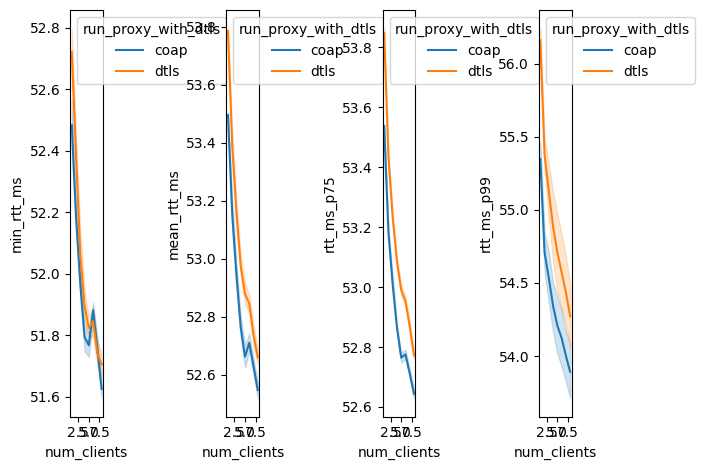

In [12]:
df = client_rps_df

ys = ["min_rtt_ms", "mean_rtt_ms", "rtt_ms_p75", "rtt_ms_p99"]
fig, ax = plt.subplots(1, len(ys))
for i, y in enumerate(ys):
  g = sns.lineplot(
    data=df,
    x="num_clients",
    y=y,
    hue="run_proxy_with_dtls",
    ax=ax[i]
  )

fig.tight_layout()
plt.show()

In [13]:
_df5 = pl.read_csv("/home/ubuntu/dos-californium/deter/expdata/real/final/thesis_group_num_clients_coap_https_5clients_noattacker__140sec_proxy__30sec_attacker__120sec_client/1/proxy_dump.pcap.connections.out", sep=";", quote_char='"')
_df6 = pl.read_csv("/home/ubuntu/dos-californium/deter/expdata/real/final/thesis_group_num_clients_coap_https_6clients_noattacker__140sec_proxy__30sec_attacker__120sec_client/1/proxy_dump.pcap.connections.out", sep=";", quote_char='"')

_cdf5 = _df5[
  (_df5["_ws.col.Protocol"] == "TCP")
  & (
    ((_df5["tcp.flags.syn"] == 1 ) & (_df5["tcp.srcport"] != 443 )) 
    | ((_df5["tcp.flags.fin"] == 1 ) & (_df5["tcp.srcport"] != 443 ))
  )
]
_cdf5["syn_sum"] = _cdf5["tcp.flags.syn"].cumsum()
_cdf5["fin_sum"] = _cdf5["tcp.flags.fin"].cumsum()
_cdf5["cumulative_egress_connections"] = _cdf5["syn_sum"] - _cdf5["fin_sum"]

_cdf6 = _df6[
  (_df6["_ws.col.Protocol"] == "TCP")
  & (
    ((_df6["tcp.flags.syn"] == 1 ) & (_df6["tcp.srcport"] != 443 )) 
    | ((_df6["tcp.flags.fin"] == 1 ) & (_df6["tcp.srcport"] != 443 ))
  )
]
_cdf6["syn_sum"] = _cdf6["tcp.flags.syn"].cumsum()
_cdf6["fin_sum"] = _cdf6["tcp.flags.fin"].cumsum()
_cdf6["cumulative_egress_connections"] = _cdf6["syn_sum"] - _cdf6["fin_sum"]

_cdf5

shape: (10, 13)
┌────────────┬────────────┬────────────┬───────────┬─────┬────────────┬─────────┬─────────┬────────────┐
│ _ws.col.Ti ┆ _ws.col.So ┆ _ws.col.De ┆ tcp.srcpo ┆ ... ┆ _ws.col.In ┆ syn_sum ┆ fin_sum ┆ cumulative │
│ me         ┆ urce       ┆ stination  ┆ rt        ┆     ┆ fo         ┆ ---     ┆ ---     ┆ _egress_co │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆     ┆ ---        ┆ i64     ┆ i64     ┆ nnections  │
│ f64        ┆ str        ┆ str        ┆ i64       ┆     ┆ str        ┆         ┆         ┆ ---        │
│            ┆            ┆            ┆           ┆     ┆            ┆         ┆         ┆ i64        │
╞════════════╪════════════╪════════════╪═══════════╪═════╪════════════╪═════════╪═════════╪════════════╡
│ 0.052243   ┆ 10.1.88.1  ┆ 10.1.1.1   ┆ 40560     ┆ ... ┆ 40560 →    ┆ 1       ┆ 0       ┆ 1          │
│            ┆            ┆            ┆           ┆     ┆ 443 [SYN]  ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ Seq=0 Win= ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ 6424...    ┆         ┆         ┆            │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 2.080962   ┆ 10.1.88.1  ┆ 10.1.1.1   ┆ 40562     ┆ ... ┆ 40562 →    ┆ 2       ┆ 0       ┆ 2          │
│            ┆            ┆            ┆           ┆     ┆ 443 [SYN]  ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ Seq=0 Win= ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ 6424...    ┆         ┆         ┆            │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 3.149015   ┆ 10.1.88.1  ┆ 10.1.1.1   ┆ 40564     ┆ ... ┆ 40564 →    ┆ 3       ┆ 0       ┆ 3          │
│            ┆            ┆            ┆           ┆     ┆ 443 [SYN]  ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ Seq=0 Win= ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ 6424...    ┆         ┆         ┆            │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.160475   ┆ 10.1.88.1  ┆ 10.1.1.1   ┆ 40566     ┆ ... ┆ 40566 →    ┆ 4       ┆ 0       ┆ 4          │
│            ┆            ┆            ┆           ┆     ┆ 443 [SYN]  ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ Seq=0 Win= ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ 6424...    ┆         ┆         ┆            │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...        ┆ ...        ┆ ...        ┆ ...       ┆ ... ┆ ...        ┆ ...     ┆ ...     ┆ ...        │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 125.585135 ┆ 10.1.88.1  ┆ 10.1.1.1   ┆ 40562     ┆ ... ┆ 40562 →    ┆ 5       ┆ 2       ┆ 3          │
│            ┆            ┆            ┆           ┆     ┆ 443 [FIN,  ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ ACK] Seq=3 ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ 6716...    ┆         ┆         ┆            │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 126.589447 ┆ 10.1.88.1  ┆ 10.1.1.1   ┆ 40564     ┆ ... ┆ 40564 →    ┆ 5       ┆ 3       ┆ 2          │
│            ┆            ┆            ┆           ┆     ┆ 443 [FIN,  ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ ACK] Seq=3 ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ 7169...    ┆         ┆         ┆        

In [14]:
_cdf6

shape: (22, 13)
┌────────────┬────────────┬────────────┬───────────┬─────┬────────────┬─────────┬─────────┬────────────┐
│ _ws.col.Ti ┆ _ws.col.So ┆ _ws.col.De ┆ tcp.srcpo ┆ ... ┆ _ws.col.In ┆ syn_sum ┆ fin_sum ┆ cumulative │
│ me         ┆ urce       ┆ stination  ┆ rt        ┆     ┆ fo         ┆ ---     ┆ ---     ┆ _egress_co │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆     ┆ ---        ┆ i64     ┆ i64     ┆ nnections  │
│ f64        ┆ str        ┆ str        ┆ i64       ┆     ┆ str        ┆         ┆         ┆ ---        │
│            ┆            ┆            ┆           ┆     ┆            ┆         ┆         ┆ i64        │
╞════════════╪════════════╪════════════╪═══════════╪═════╪════════════╪═════════╪═════════╪════════════╡
│ 0.054046   ┆ 10.1.88.1  ┆ 10.1.1.1   ┆ 49264     ┆ ... ┆ 49264 →    ┆ 1       ┆ 0       ┆ 1          │
│            ┆            ┆            ┆           ┆     ┆ 443 [SYN]  ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ Seq=0 Win= ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ 6424...    ┆         ┆         ┆            │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 0.961427   ┆ 10.1.88.1  ┆ 10.1.1.1   ┆ 49266     ┆ ... ┆ 49266 →    ┆ 2       ┆ 0       ┆ 2          │
│            ┆            ┆            ┆           ┆     ┆ 443 [SYN]  ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ Seq=0 Win= ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ 6424...    ┆         ┆         ┆            │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 1.996059   ┆ 10.1.88.1  ┆ 10.1.1.1   ┆ 49268     ┆ ... ┆ 49268 →    ┆ 3       ┆ 0       ┆ 3          │
│            ┆            ┆            ┆           ┆     ┆ 443 [SYN]  ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ Seq=0 Win= ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ 6424...    ┆         ┆         ┆            │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 3.060682   ┆ 10.1.88.1  ┆ 10.1.1.1   ┆ 49270     ┆ ... ┆ 49270 →    ┆ 4       ┆ 0       ┆ 4          │
│            ┆            ┆            ┆           ┆     ┆ 443 [SYN]  ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ Seq=0 Win= ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ 6424...    ┆         ┆         ┆            │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...        ┆ ...        ┆ ...        ┆ ...       ┆ ... ┆ ...        ┆ ...     ┆ ...     ┆ ...        │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 125.28569  ┆ 10.1.88.1  ┆ 10.1.1.1   ┆ 49284     ┆ ... ┆ 49284 →    ┆ 11      ┆ 8       ┆ 3          │
│            ┆            ┆            ┆           ┆     ┆ 443 [FIN,  ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ ACK] Seq=5 ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ 7994...    ┆         ┆         ┆            │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 125.285841 ┆ 10.1.88.1  ┆ 10.1.1.1   ┆ 49268     ┆ ... ┆ 49268 →    ┆ 11      ┆ 9       ┆ 2          │
│            ┆            ┆            ┆           ┆     ┆ 443 [FIN,  ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ ACK] Seq=5 ┆         ┆         ┆            │
│            ┆            ┆            ┆           ┆     ┆ 8492...    ┆         ┆         ┆        

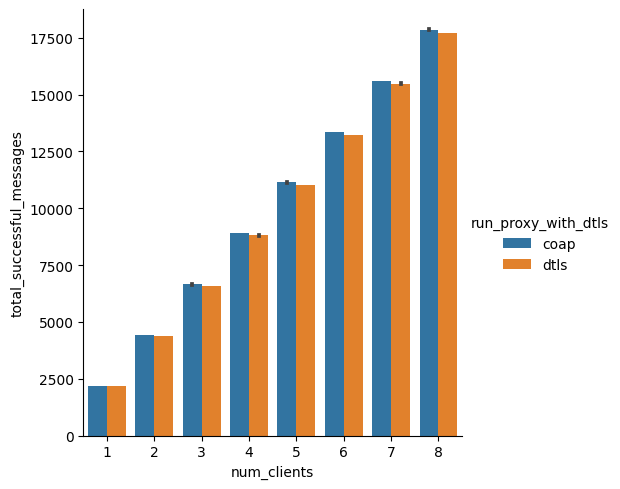

exp_id  \
0   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                   ...   
75  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
76  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
77  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
78  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
79  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

   run_proxy_with_dtls  num_clients  trial  total_successful_messages  
0                 coap            1      1                       2192  
1                 coap            1      2                       2194  
2                 coap            1      3                       2193  
3                 coap            1      4                       2195  
4                 coap            1      5                       2194  
..                 ...          ...    ...                        ...  
75                dtls            8      1                      17706  
76                dtls            8      2                      17691  
77                dtls            8      3                      17682  
78                dtls            8      4                      17715  
79                dtls            8      5                      17724  

[80 rows x 5 columns]

In [15]:
df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum")
  )
  .reset_index()
)

g = sns.catplot(
  data=df,
  x="num_clients",
  y="total_successful_messages",
  hue="run_proxy_with_dtls",
  kind="bar",
)

plt.show()

df

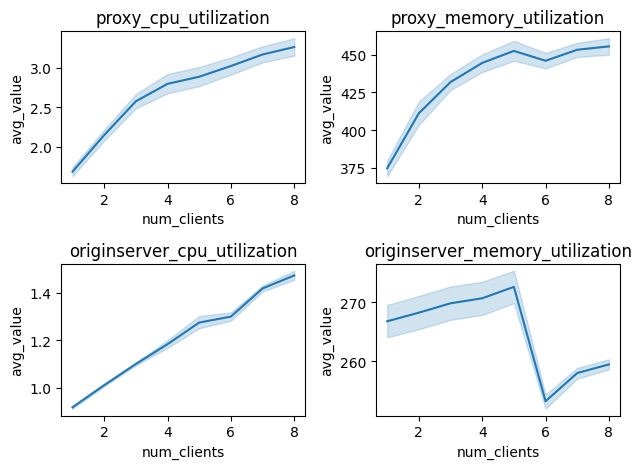

exp_id  \
0    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                    ...   
315  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
316  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
317  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
318  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
319  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

     trial   observer_id         metric_type   avg_value  min_value  \
0        1  originserver     cpu_utilization    0.935714        0.3   
1        1         proxy     cpu_utilization    1.565000        0.5   
2        1  originserver  memory_utilization  261.662810      250.0   
3        1         proxy  memory_utilization  366.561983      251.0   
4        2  originserver     cpu_utilization    0.927143        0.3   
..     ...           ...                 ...         ...        ...   
315      4         proxy  memory_utilization  462.127273      245.0   
316      5  originserver     cpu_utilization    1.485714        0.4   
317      5         proxy     cpu_utilization    3.462143        0.5   
318      5  originserver  memory_utilization  260.966997      247.0   
319      5         proxy  memory_utilization  466.800000      244.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         11.5         0mbps                 256                        0   
1         21.2         0mbps                 256                        0   
2        263.0         0mbps                 256                        0   
3        404.0         0mbps                 256                        0   
4         10.0         0mbps                 256                        0   
..         ...           ...                 ...                      ...   
315      495.0         0mbps                 256                        0   
316        9.2         0mbps                 256                        0   
317       26.5         0mbps                 256                        0   
318      262.0         0mbps                 256                        0   
319      503.0         0mbps                 256                        0   

     ...                             topology_name  num_proxy_connections  \
0    ...  thesis_cloud_proxy_and_internet_attacker                     50   
1    ...  thesis_cloud_proxy_and_internet_attacker                     50   
2    ...  thesis_cloud_proxy_and_internet_attacker                     50   
3    ...  thesis_cloud_proxy_and_internet_attacker                     50   
4    ...  thesis_cloud_proxy_and_internet_attacker                     50   
..   ...                                       ...                    ...   
315  ...  thesis_cloud_proxy_and_internet_attacker                     50   
316  ...  thesis_cloud_proxy_and_internet_attacker                     50   
317  ...  thesis_cloud_proxy_and_internet_attacker                     50   
318  ...  thesis_cloud_proxy_and_internet_attacker                     50   
319  ...  thesis_cloud_proxy_and_internet_attacker                     50   

     request_timeout  max_retries  keep_alive_duration  \
0                  5         

In [16]:
df = metric_df

nodes = ["proxy", "originserver"]
metric_types = ["cpu_utilization", "memory_utilization"]
fig, ax = plt.subplots(len(metric_types), len(nodes))
for i, n in enumerate(nodes):
  for j, m in enumerate(metric_types):
    g = sns.lineplot(
      data=df[
        (df["observer_id"] == n)
        & (df["metric_type"] == m)
      ],
      x="num_clients",
      y="avg_value",
      ax=ax[i,j],
    )
    ax[i,j].set_title(f"{n}_{m}")

fig.tight_layout()
plt.show()

df

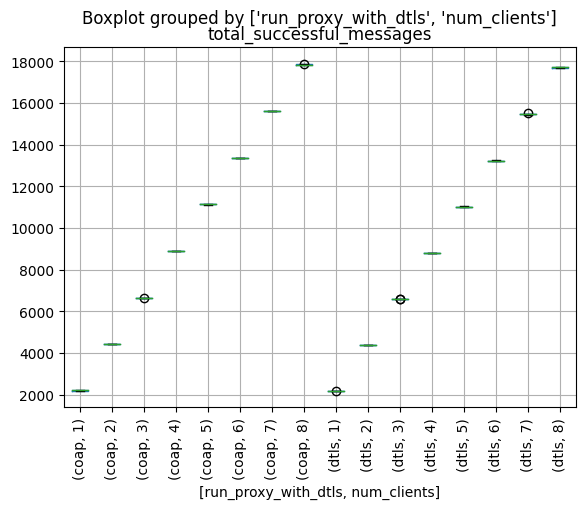

total_successful_messages
exp_id                                                                                               run_proxy_with_dtls num_clients trial                           
thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client coap                1           1                           2192
                                                                                                                                     2                           2194
                                                                                                                                     3                           2193
                                                                                                                                     4                           2195
                                                                                                                                     5                           2194
...                                                                                                                                                               ...
thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client dtls                8           1                          17706
                                                                                                                                     2                          17691
                                                                                                                                     3                          17682
                                                                                                                                     4                          17715
                                                                                                                                     5                          17724

[80 rows x 1 columns]

In [17]:
df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum")
  )
)
param_comparison_scope = ["run_proxy_with_dtls", "num_clients"]

plot_args = {
  "rot": 90,
  "by": param_comparison_scope,
}

df.boxplot("total_successful_messages", **plot_args)

plt.show()

df

In [31]:
### At this point, we generate figures for the paper

plt.rcParams['figure.dpi']  = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['font.size']        = '18'
plt.rcParams['lines.linewidth']  = 3
plt.rcParams['lines.markersize'] = 9

client_rps_df.replace({
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    "dtls": "CoAPS",
  }
}, inplace=True)
metric_df.replace({
  "run_proxy_with_dtls": {
    False: "CoAP",
    True : "CoAPS",
  }
}, inplace=True)

In [32]:
### At this point, we generate figures for the paper

client_rps_df.replace({
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    "dtls": "CoAPS",
  }
}, inplace=True)

def get_properties(y):
  if y == "mean_rtt_ms":
    title = "Meant Client RTT in Milliseconds"
    ylabel = title + " Milliseconds"
  elif y == "rtt_ms_p99":
    title = "99th Percentile Client RTT in Milliseconds"
    ylabel = title + " in Milliseconds"
  else:
    raise Exception()

  ylabel = "Client RTT in Milliseconds"
  
  return {
    "ylabel": ylabel,
    "title": title,
  }

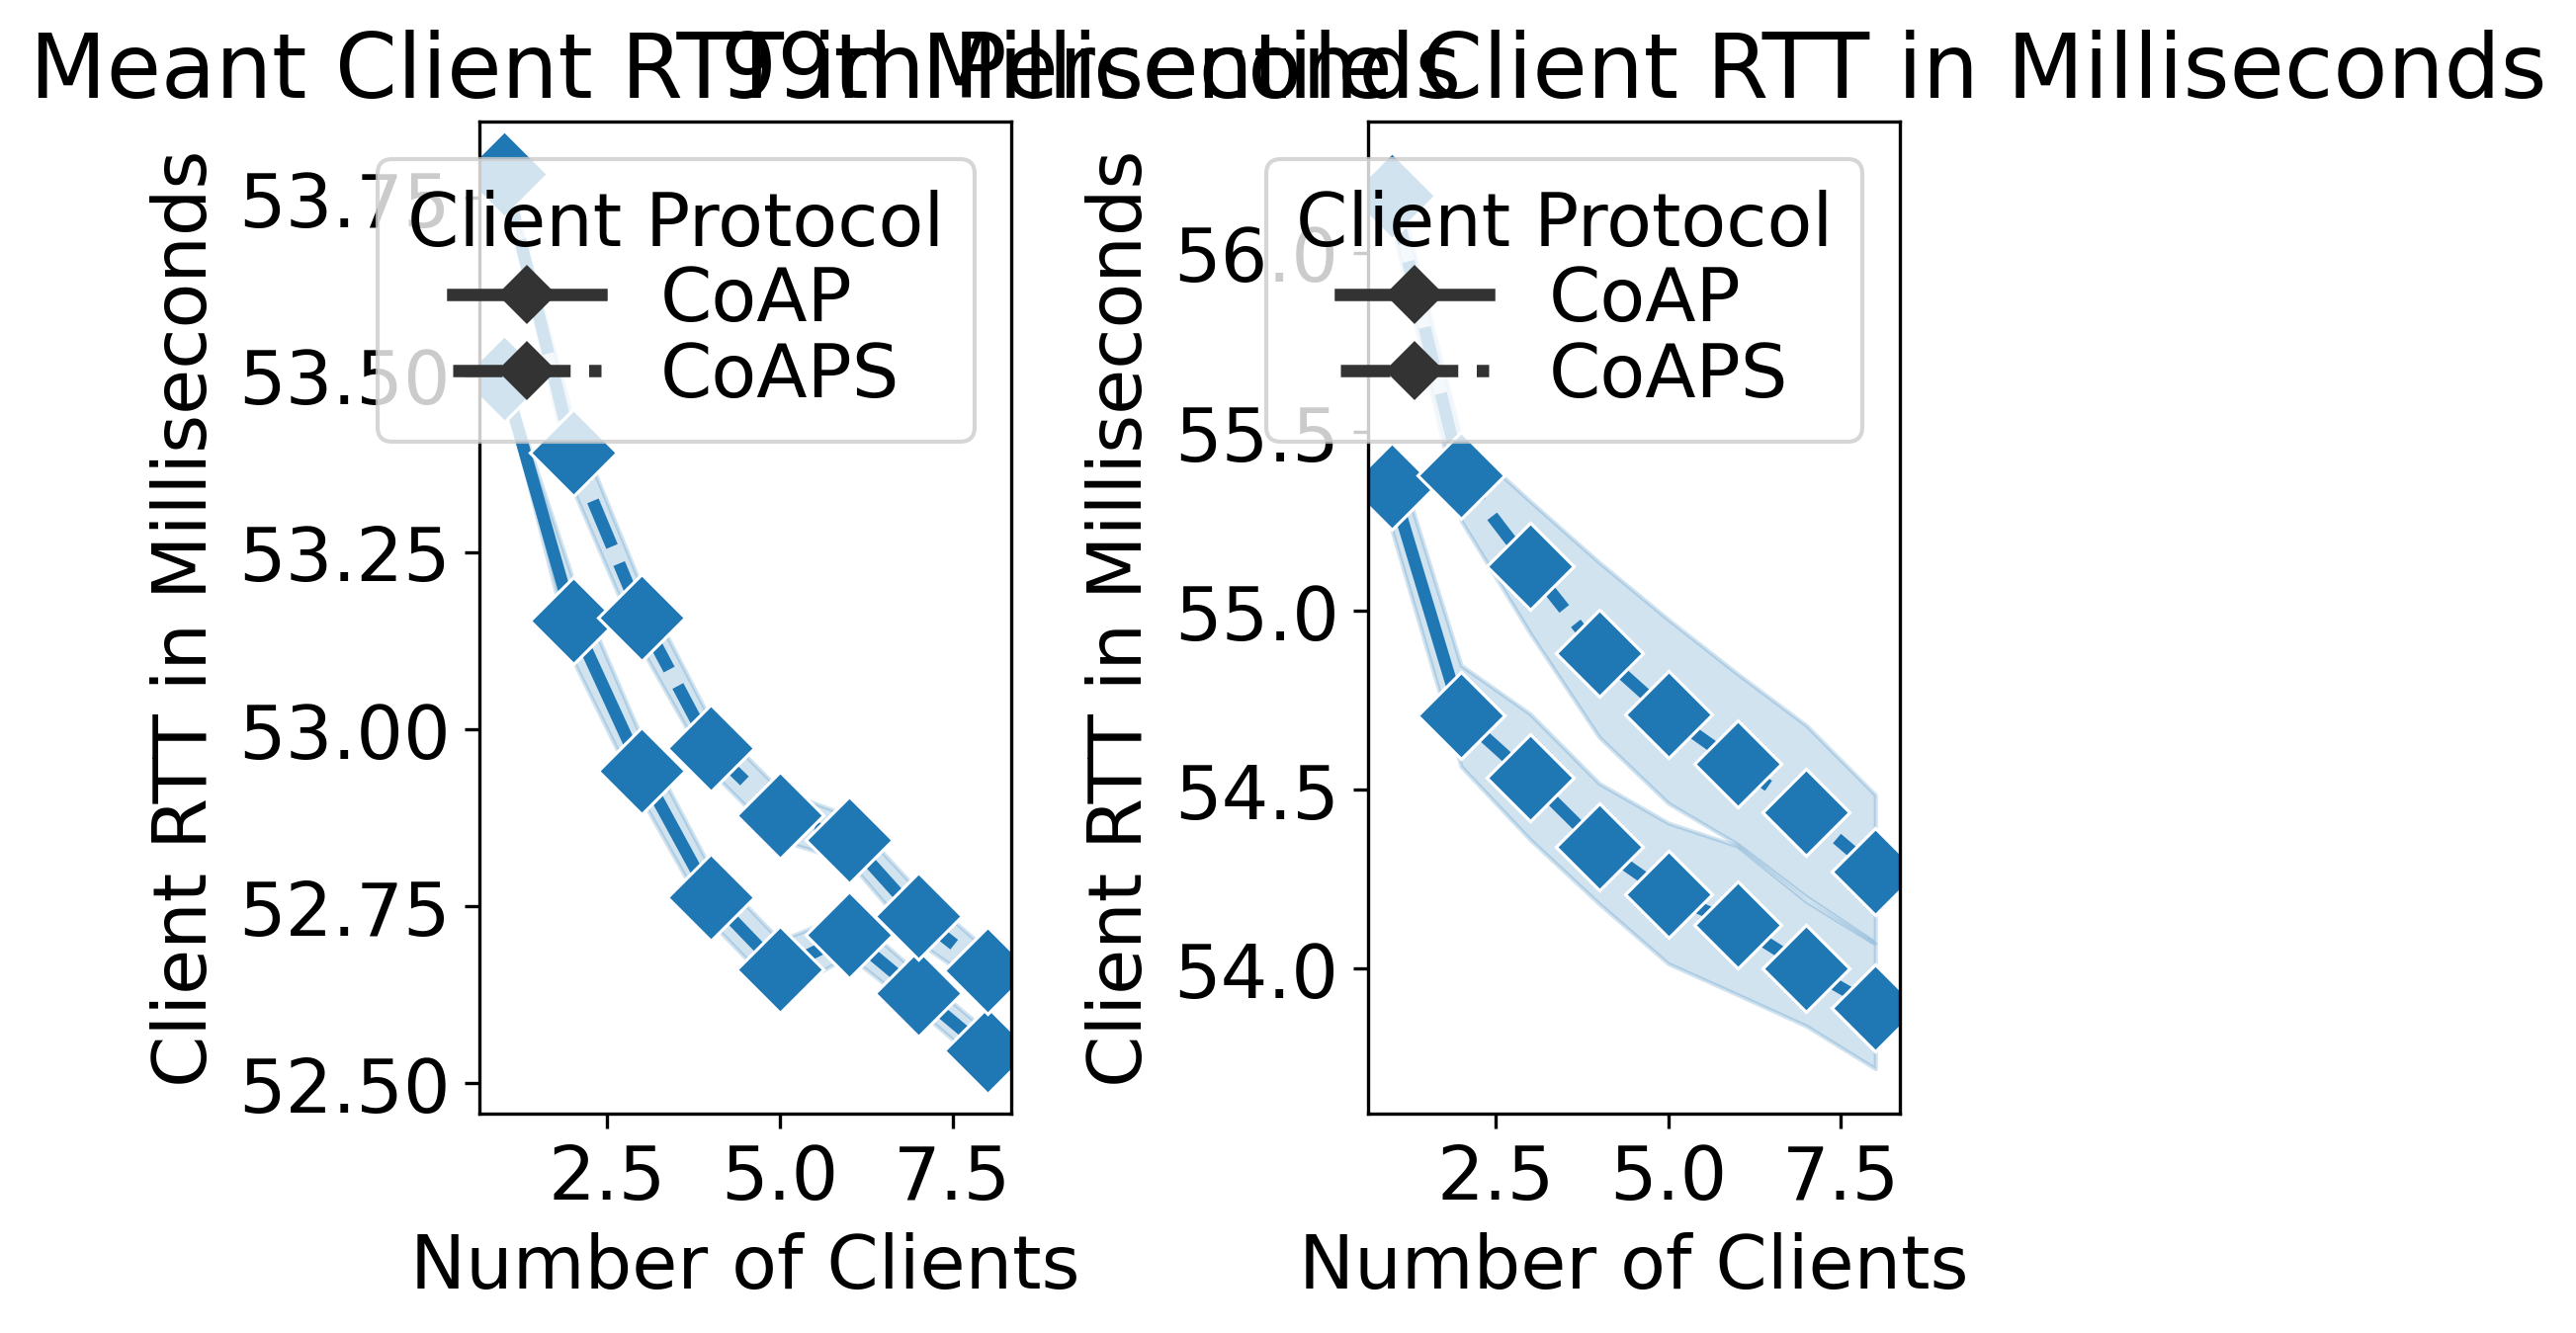

In [34]:
### Plot effect of RTT as a result of increasing number of clients

df = client_rps_df

ys = ["mean_rtt_ms", "rtt_ms_p99"]
fig, ax = plt.subplots(1, len(ys))
for i, y in enumerate(ys):
  g = sns.lineplot(
    data=df,
    x="num_clients",
    y=y,
    style="run_proxy_with_dtls",
    ax=ax[i],
    markers=["D", "D"],
    markersize=15,
  )

  sns.move_legend(
    g, 
    "upper right", 
    title="Client Protocol", 
    frameon=True, 
    labelspacing=0.05,
    bbox_to_anchor=((1, 1)),
    markerfirst=True,
  )

  props = get_properties(y)
  ax[i].set_xlabel("Number of Clients")
  ax[i].set_ylabel(props["ylabel"])
  ax[i].set_title(props["title"])

fig.tight_layout(pad=1)
plt.show()

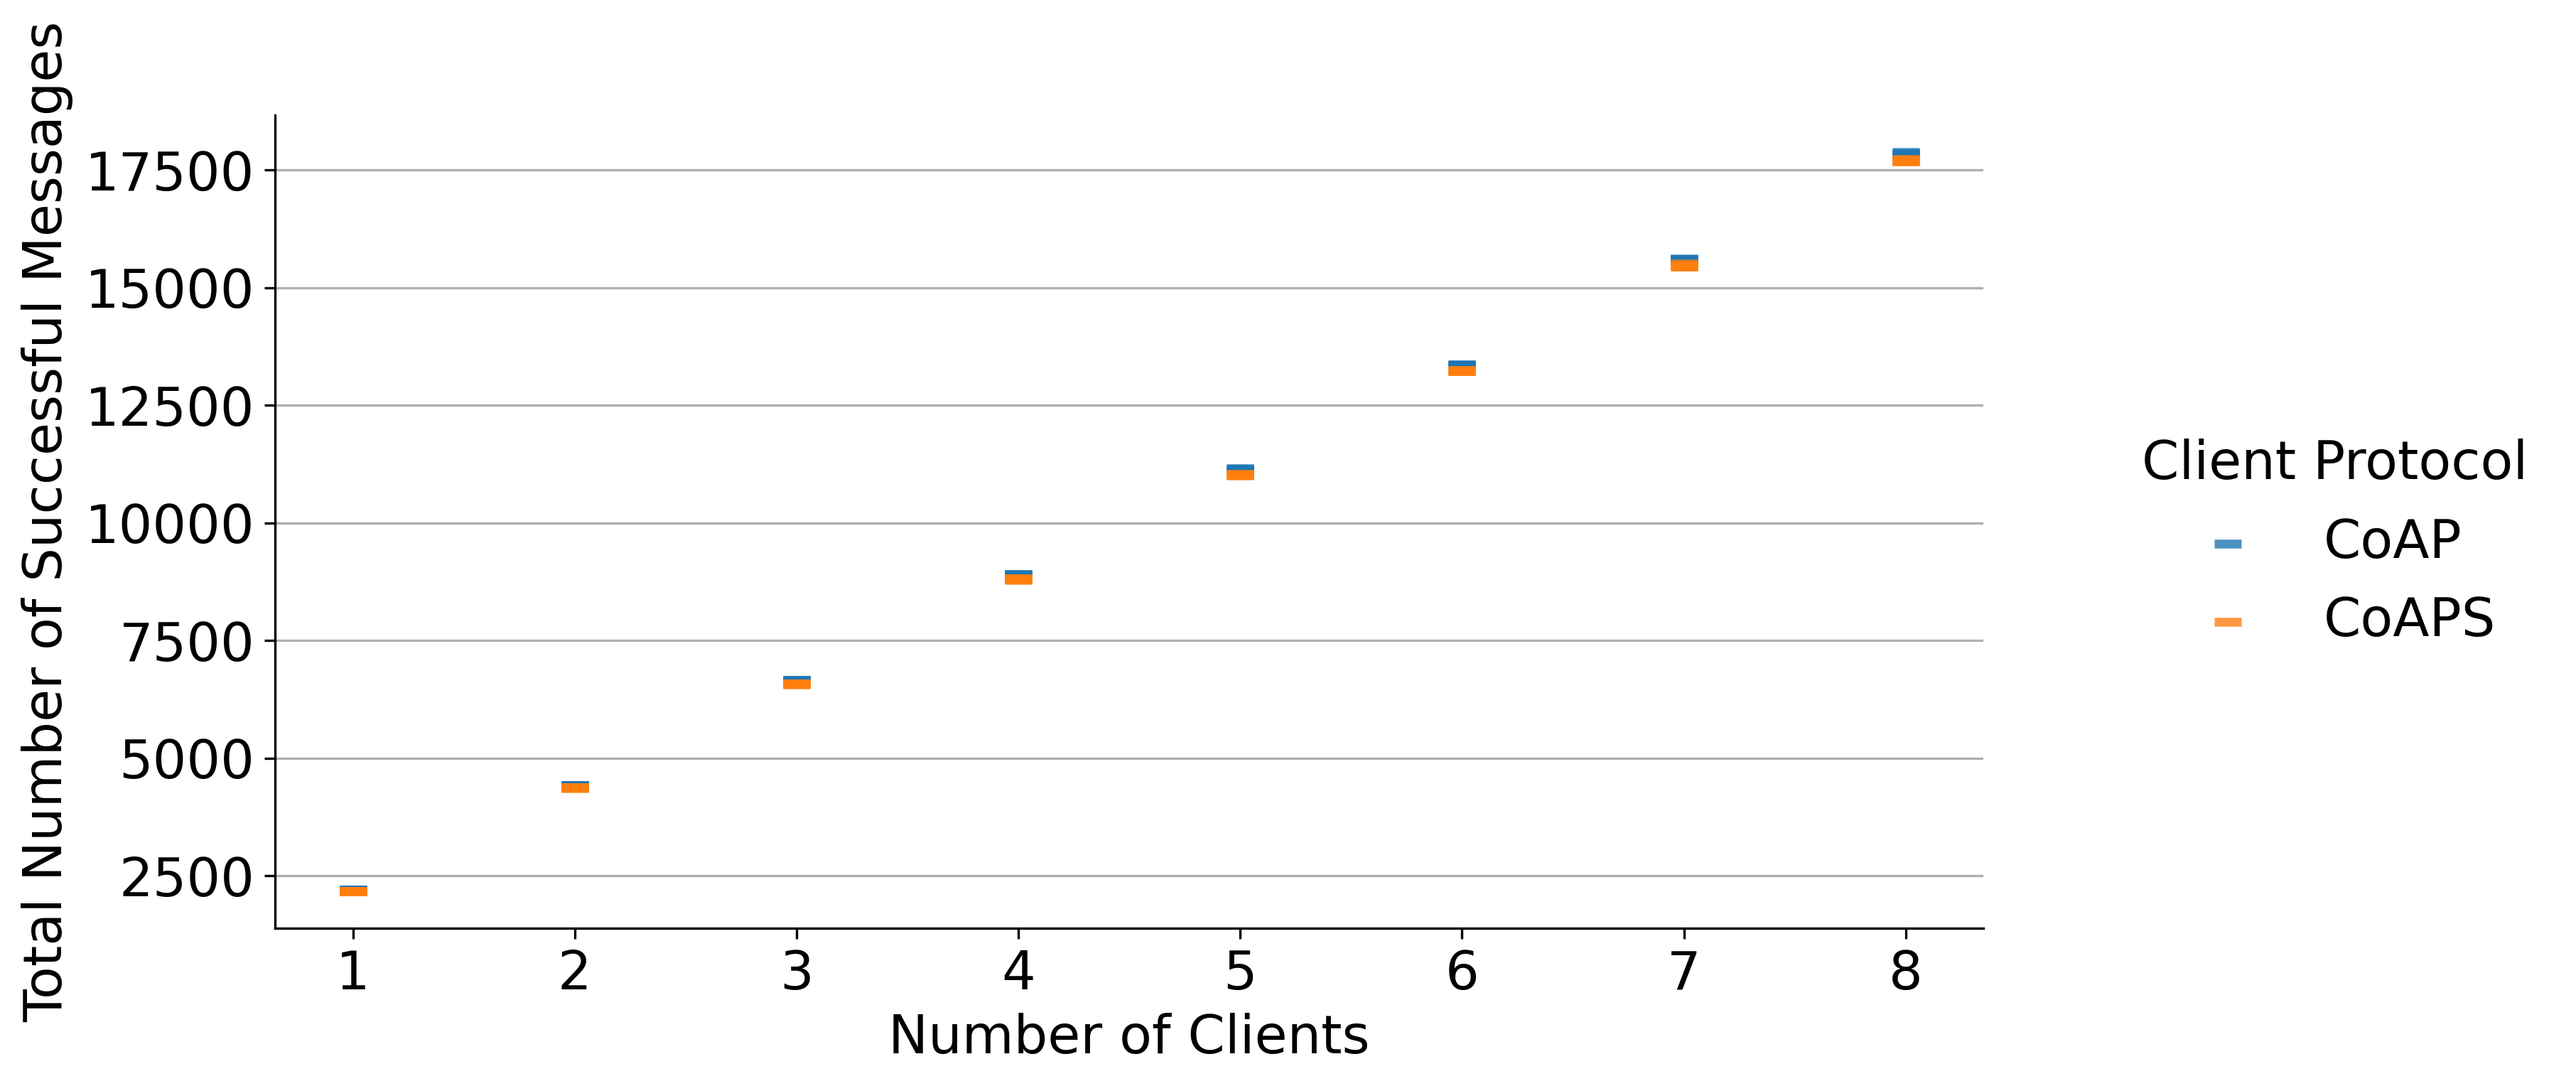

exp_id  \
0   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                   ...   
75  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
76  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
77  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
78  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
79  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

   run_proxy_with_dtls  num_clients  trial  total_successful_messages  \
0                 CoAP            1      1                       2192   
1                 CoAP            1      2                       2194   
2                 CoAP            1      3                       2193   
3                 CoAP            1      4                       2195   
4                 CoAP            1      5                       2194   
..                 ...          ...    ...                        ...   
75               CoAPS            8      1                      17706   
76               CoAPS            8      2                      17691   
77               CoAPS            8      3                      17682   
78               CoAPS            8      4                      17715   
79               CoAPS            8      5                      17724   

    mean_active_time_sec  amortized_successful_rps  
0             119.164637                 18.394719  
1             119.121195                 18.418217  
2             119.125083                 18.409221  
3             119.177281                 18.417940  
4             119.144843                 18.414561  
..                   ...                       ...  
75            118.897997                 18.614695  
76            118.889265                 18.600292  
77            118.911157                 18.587406  
78            118.891196                 18.625223  
79            118.905295                 18.632476  

[80 rows x 7 columns]

In [23]:
## Plot total number of successful messages.

client_rps_df["active_time_sec"] = client_rps_df["last_active_time"] - client_rps_df["first_active_time"]

df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum"),
    mean_active_time_sec=("active_time_sec", "mean"),
  )
  .reset_index()
)
df["amortized_successful_rps"] = df["total_successful_messages"] / df["mean_active_time_sec"] / df["num_clients"]

g = sns.lmplot(
  data=df,
  x="num_clients",
  y="total_successful_messages",
  hue="run_proxy_with_dtls",
  aspect=2,
  markers=["_", "_"],
  scatter=True,
  fit_reg=False,
)

g.set_xlabels("Number of Clients")
g.set_ylabels("Total Number of Successful Messages")
g.legend.set_title("Client Protocol")
# g.refline(
#   y=100.0,
#   color="black",
#   linestyle="solid",
#   linewidth=0.05,
# )

plt.grid(True, axis="y")
plt.show()

df

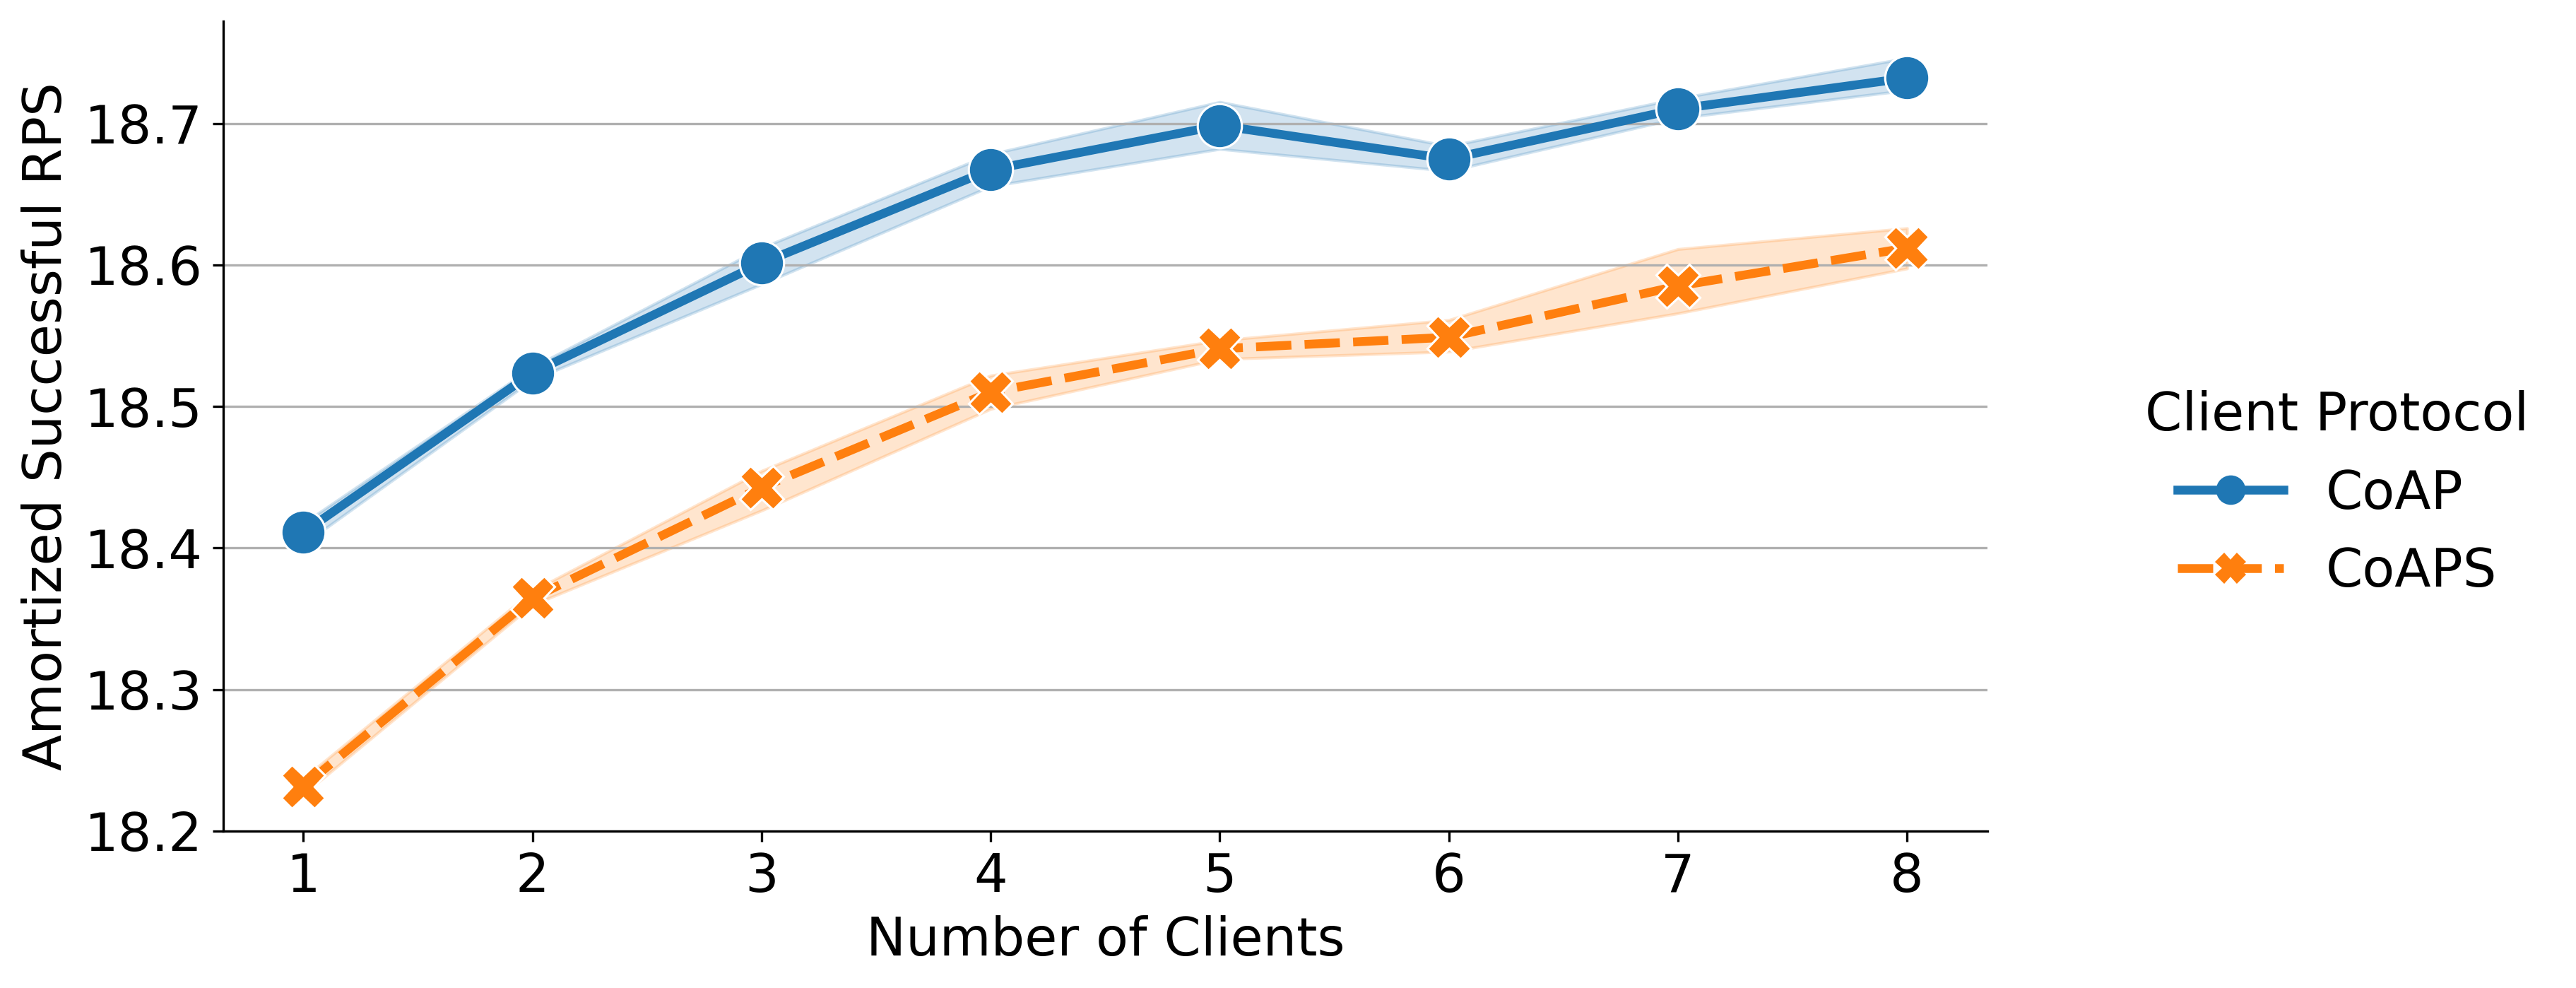

exp_id  \
0   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                   ...   
75  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
76  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
77  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
78  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
79  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

   run_proxy_with_dtls  num_clients  trial  total_successful_messages  \
0                 CoAP            1      1                       2192   
1                 CoAP            1      2                       2194   
2                 CoAP            1      3                       2193   
3                 CoAP            1      4                       2195   
4                 CoAP            1      5                       2194   
..                 ...          ...    ...                        ...   
75               CoAPS            8      1                      17706   
76               CoAPS            8      2                      17691   
77               CoAPS            8      3                      17682   
78               CoAPS            8      4                      17715   
79               CoAPS            8      5                      17724   

    mean_active_time_sec  amortized_successful_rps  
0             119.164637                 18.394719  
1             119.121195                 18.418217  
2             119.125083                 18.409221  
3             119.177281                 18.417940  
4             119.144843                 18.414561  
..                   ...                       ...  
75            118.897997                 18.614695  
76            118.889265                 18.600292  
77            118.911157                 18.587406  
78            118.891196                 18.625223  
79            118.905295                 18.632476  

[80 rows x 7 columns]

In [24]:
g = sns.relplot(
  data=df,
  kind="line",
  x="num_clients",
  y="amortized_successful_rps",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  aspect=2,
  markers=True,
  markersize=15,
)

g.set_xlabels("Number of Clients")
g.set_ylabels("Amortized Successful RPS")
g.legend.set_title("Client Protocol")
# g.refline(
#   y=100.0,
#   color="black",
#   linestyle="solid",
#   linewidth=0.05,
# )

plt.grid(True, axis="y")
plt.show()

df

In [25]:
## Plot retransmissions as a function of clients and protocol.

df = (
  client_rps_df.groupby(by=["exp_id", "trial", "num_clients", "run_proxy_with_dtls"])
  .agg(
    total_num_retransmissions=("total_num_retransmissions", "sum")
  )
  .reset_index()
)

# Makes no sense to graph since there are no retransmissions.
# g = sns.catplot(
#   data=df,
#   kind="bar",
#   x="num_clients",
#   y="total_num_retransmissions",
#   hue="run_proxy_with_dtls",
# )
# plt.show()

df[df["total_num_retransmissions"] > 0]

Empty DataFrame
Columns: [exp_id, trial, num_clients, run_proxy_with_dtls, total_num_retransmissions]
Index: []

In [26]:
%%time

## Determine transaction success rate

# Combine send and receive events for clients.
client_events_df = client_sends_df.merge(client_recvs_df, on=["exp_id", "trial", "observer_id", "message_marker"], how="left")
client_events_df.rename(columns={
  "observe_timestamp_x": "send_timestamp",
  "observe_timestamp_y": "recv_timestamp",
}, inplace=True)
client_events_df["rtt_ms"] = 1e3 * (client_events_df["recv_timestamp"] - client_events_df["send_timestamp"])

# Edge case: sometimes clients will not receive a
# response back at the end of the experiment, so
# we ignore those messages, if any.
grouped_last_nan_indicies_to_remove = (
  client_events_df.reset_index()[
    client_events_df["recv_timestamp"].isna()
  ]
  .groupby(by=["exp_id", "trial", "observer_id", "message_marker"])
  .agg(
    last_nan_recv_timestamp=("recv_timestamp", "last"),
    original_index=("index", "last"),
  )
  .reset_index()
  ["original_index"]
  .unique()
)
client_events_df.drop(index=grouped_last_nan_indicies_to_remove, inplace=True)
client_events_df.reset_index(inplace=True)
client_events_df.drop(columns=["index"], inplace=True)

# Produce the total number of messages, and number 
# messages with a matching successful response.
grouped_client_events_df = (
  client_events_df
  .groupby(["exp_id", "trial", "observer_id"])
  .agg(
    unique_message_markers=("message_marker", "nunique"),
    num_successful_messages=("successful_message", "sum"),
  )
  .reset_index()
)

# Now compute the successful transaction rate.
grouped_client_events_df["transaction_success_rate"] = 100 * grouped_client_events_df["num_successful_messages"] / grouped_client_events_df["unique_message_markers"]

grouped_client_events_df = (
  grouped_client_events_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

grouped_client_events_df

CPU times: user 3.02 s, sys: 252 ms, total: 3.27 s
Wall time: 3.27 s


exp_id  \
0    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                    ...   
355  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
356  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
357  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
358  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
359  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  unique_message_markers num_successful_messages  \
0        1     client1                    2192                    2192   
1        2     client1                    2194                    2194   
2        3     client1                    2193                    2193   
3        4     client1                    2195                    2195   
4        5     client1                    2194                    2194   
..     ...         ...                     ...                     ...   
355      5     client4                    2210                    2210   
356      5     client5                    2218                    2218   
357      5     client6                    2218                    2218   
358      5     client7                    2220                    2220   
359      5     client8                    2219                    2219   

    transaction_success_rate attacker_rate  server_connections  \
0                      100.0         0mbps                 256   
1                      100.0         0mbps                 256   
2                      100.0         0mbps                 256   
3                      100.0         0mbps                 256   
4                      100.0         0mbps                 256   
..                       ...           ...                 ...   
355                    100.0         0mbps                 256   
356                    100.0         0mbps                 256   
357                    100.0         0mbps                 256   
358                    100.0         0mbps                 256   
359                    100.0         0mbps                 256   

     max_keep_alive_requests  num_clients  ...  \
0                          0            1  ...   
1                          0            1  ...   
2                          0            1  ...   
3                          0            1  ...   
4                          0            1  ...   
..                       ...          ...  ...   
355                        0            8  ...   
356                        0            8  ...   
357                        0            8  ...   
358                        0            8  ...   
359                        0            8  ...   

                                topology_name  num_proxy_connections  \
0    thesis_cloud_proxy_and_internet_attacker                     50   
1    thesis_cloud_proxy_and_internet_attacker                     50   
2    thesis_cloud_proxy_and_internet_attacker                     50   
3    thesis_cloud_proxy_and_internet_attacker                     50   
4    thesis_cloud_proxy_and_internet_attacker                     50   
..                                        ...                    ...   
355

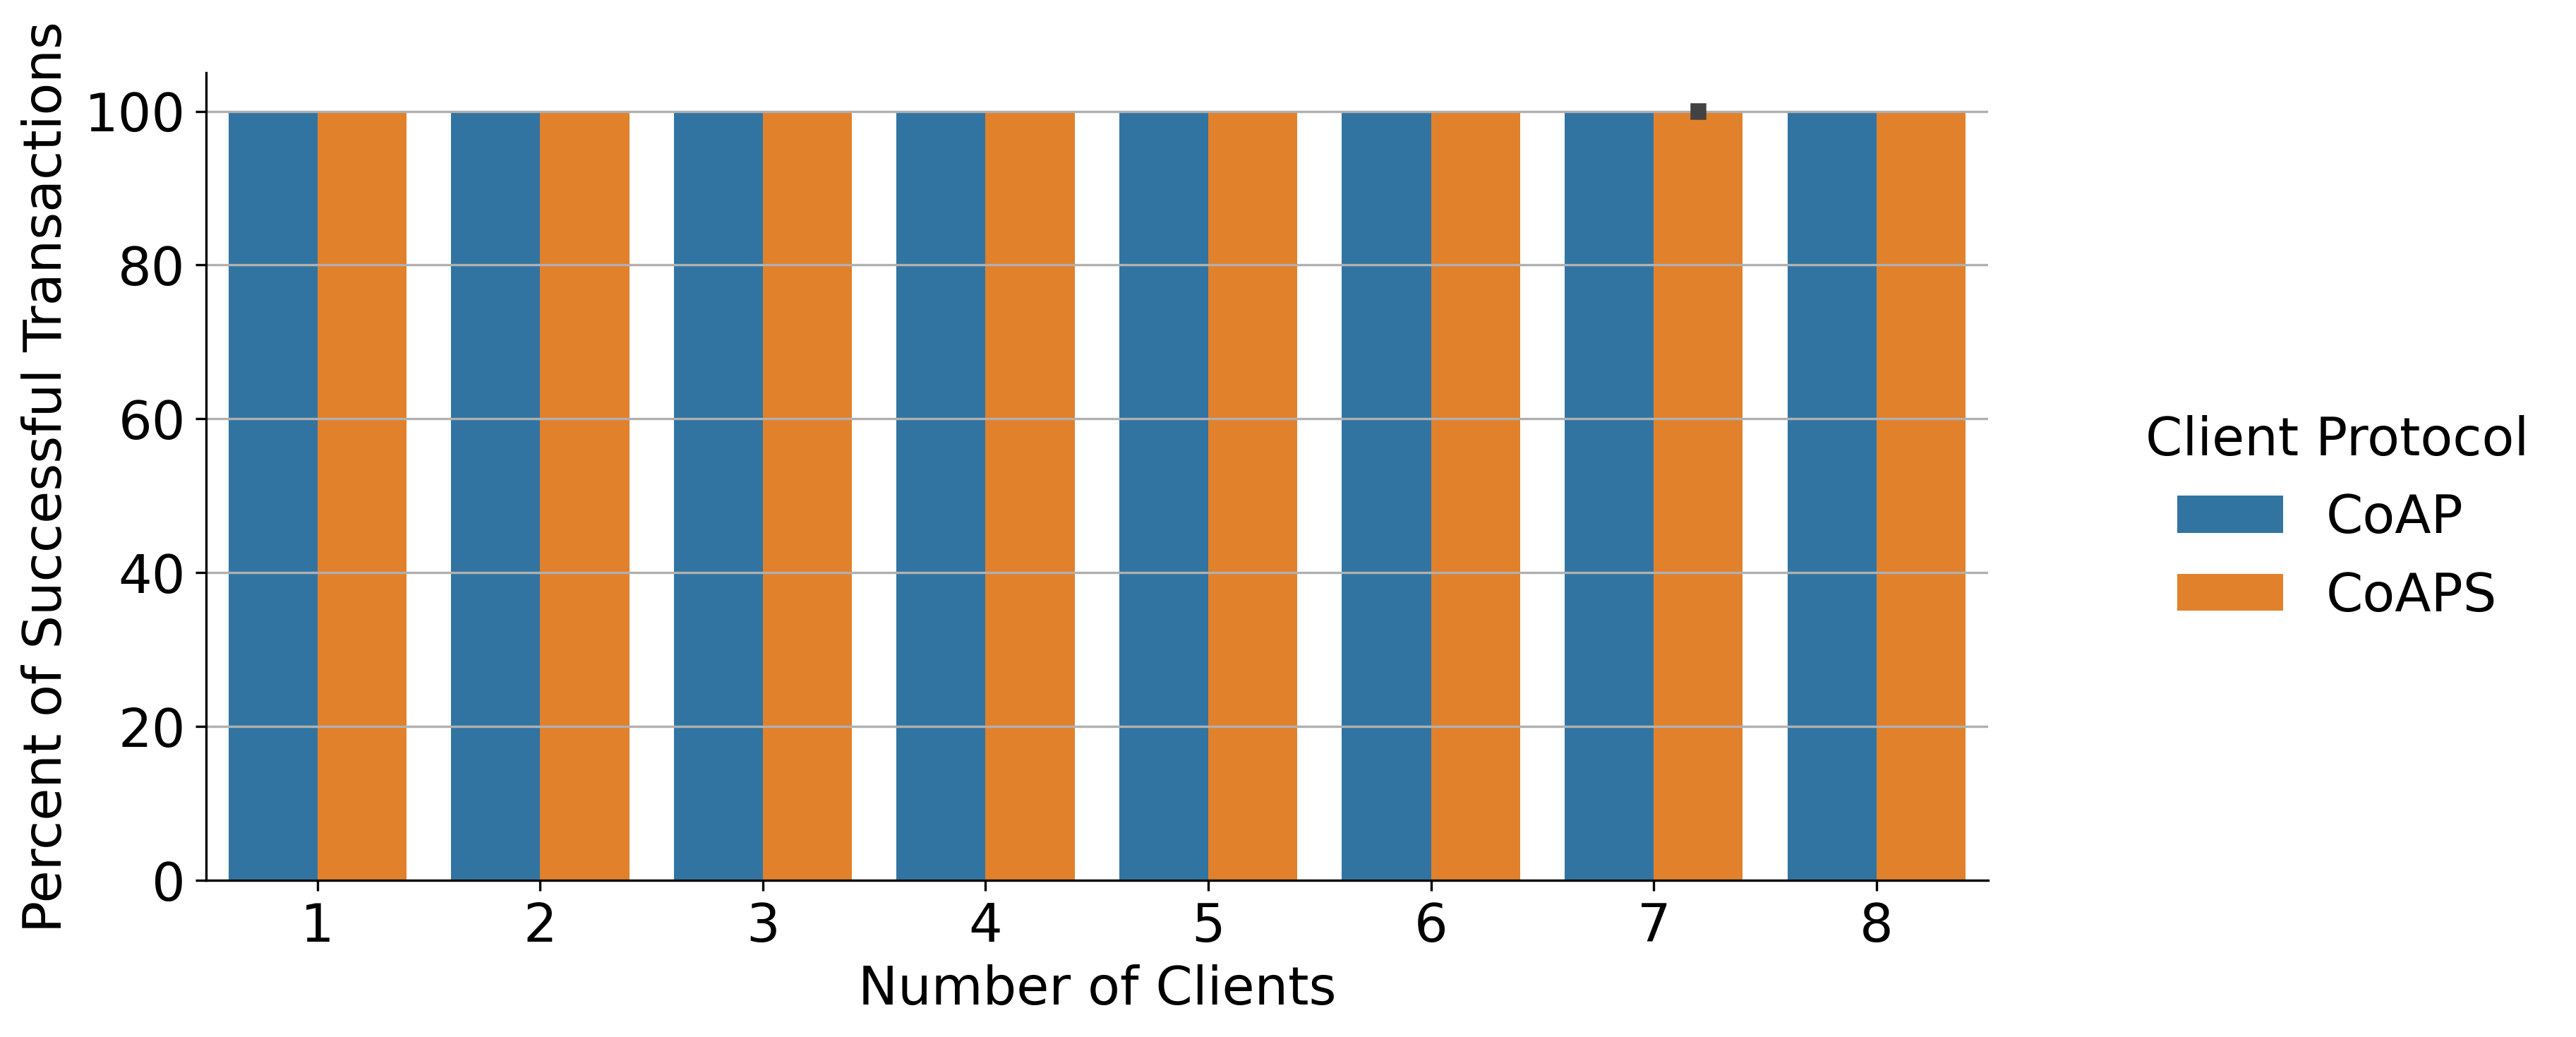

exp_id  \
315  thesis_group_num_clients_dtls_https_7clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  unique_message_markers num_successful_messages  \
315      5     client3                    2211                    2210   

    transaction_success_rate attacker_rate  server_connections  \
315                99.954772         0mbps                 256   

     max_keep_alive_requests  num_clients  ...  \
315                        0            7  ...   

                                topology_name  num_proxy_connections  \
315  thesis_cloud_proxy_and_internet_attacker                     50   

     request_timeout  max_retries  keep_alive_duration  \
315                5            2                    5   

     request_retry_interval  reuse_connections run_proxy_with_dtls  \
315                       1               True               CoAPS   

     run_proxy_with_https run_attacker  
315                  True        False  

[1 rows x 27 columns]

In [27]:
df = grouped_client_events_df

g = sns.catplot(
  data=df,
  kind="bar",
  x="num_clients",
  y="transaction_success_rate",
  hue="run_proxy_with_dtls",
  ci="sd",
  aspect=2,
)

g.set_xlabels("Number of Clients")
g.set_ylabels("Percent of Successful Transactions")
g.legend.set_title("Client Protocol")
# g.refline(
#   y=100.0,
#   color="black",
#   linestyle="solid",
#   linewidth=0.05,
# )

plt.grid(True, axis="y")
plt.show()

grouped_client_events_df[
  grouped_client_events_df["transaction_success_rate"] < 100
]

In [28]:
_df = client_events_df
tdf = _df[
  (_df["exp_id"] == "thesis_group_num_clients_dtls_https_7clients_noattacker__140sec_proxy__30sec_attacker__120sec_client")
  & (_df["trial"] == 5)
  & (_df["observer_id"] == "client3")
].reset_index().drop(columns=["index"])
tdf[
  tdf["response_code"] != "content"
]

exp_id  \
207  thesis_group_num_clients_dtls_https_7clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

     send_timestamp  trial observer_id  message_marker  coap_retransmitted  \
207       13.544313      5     client3            1313               False   

     recv_timestamp response_code successful_message     rtt_ms  
207       13.599317   bad_gateway              False  55.003881

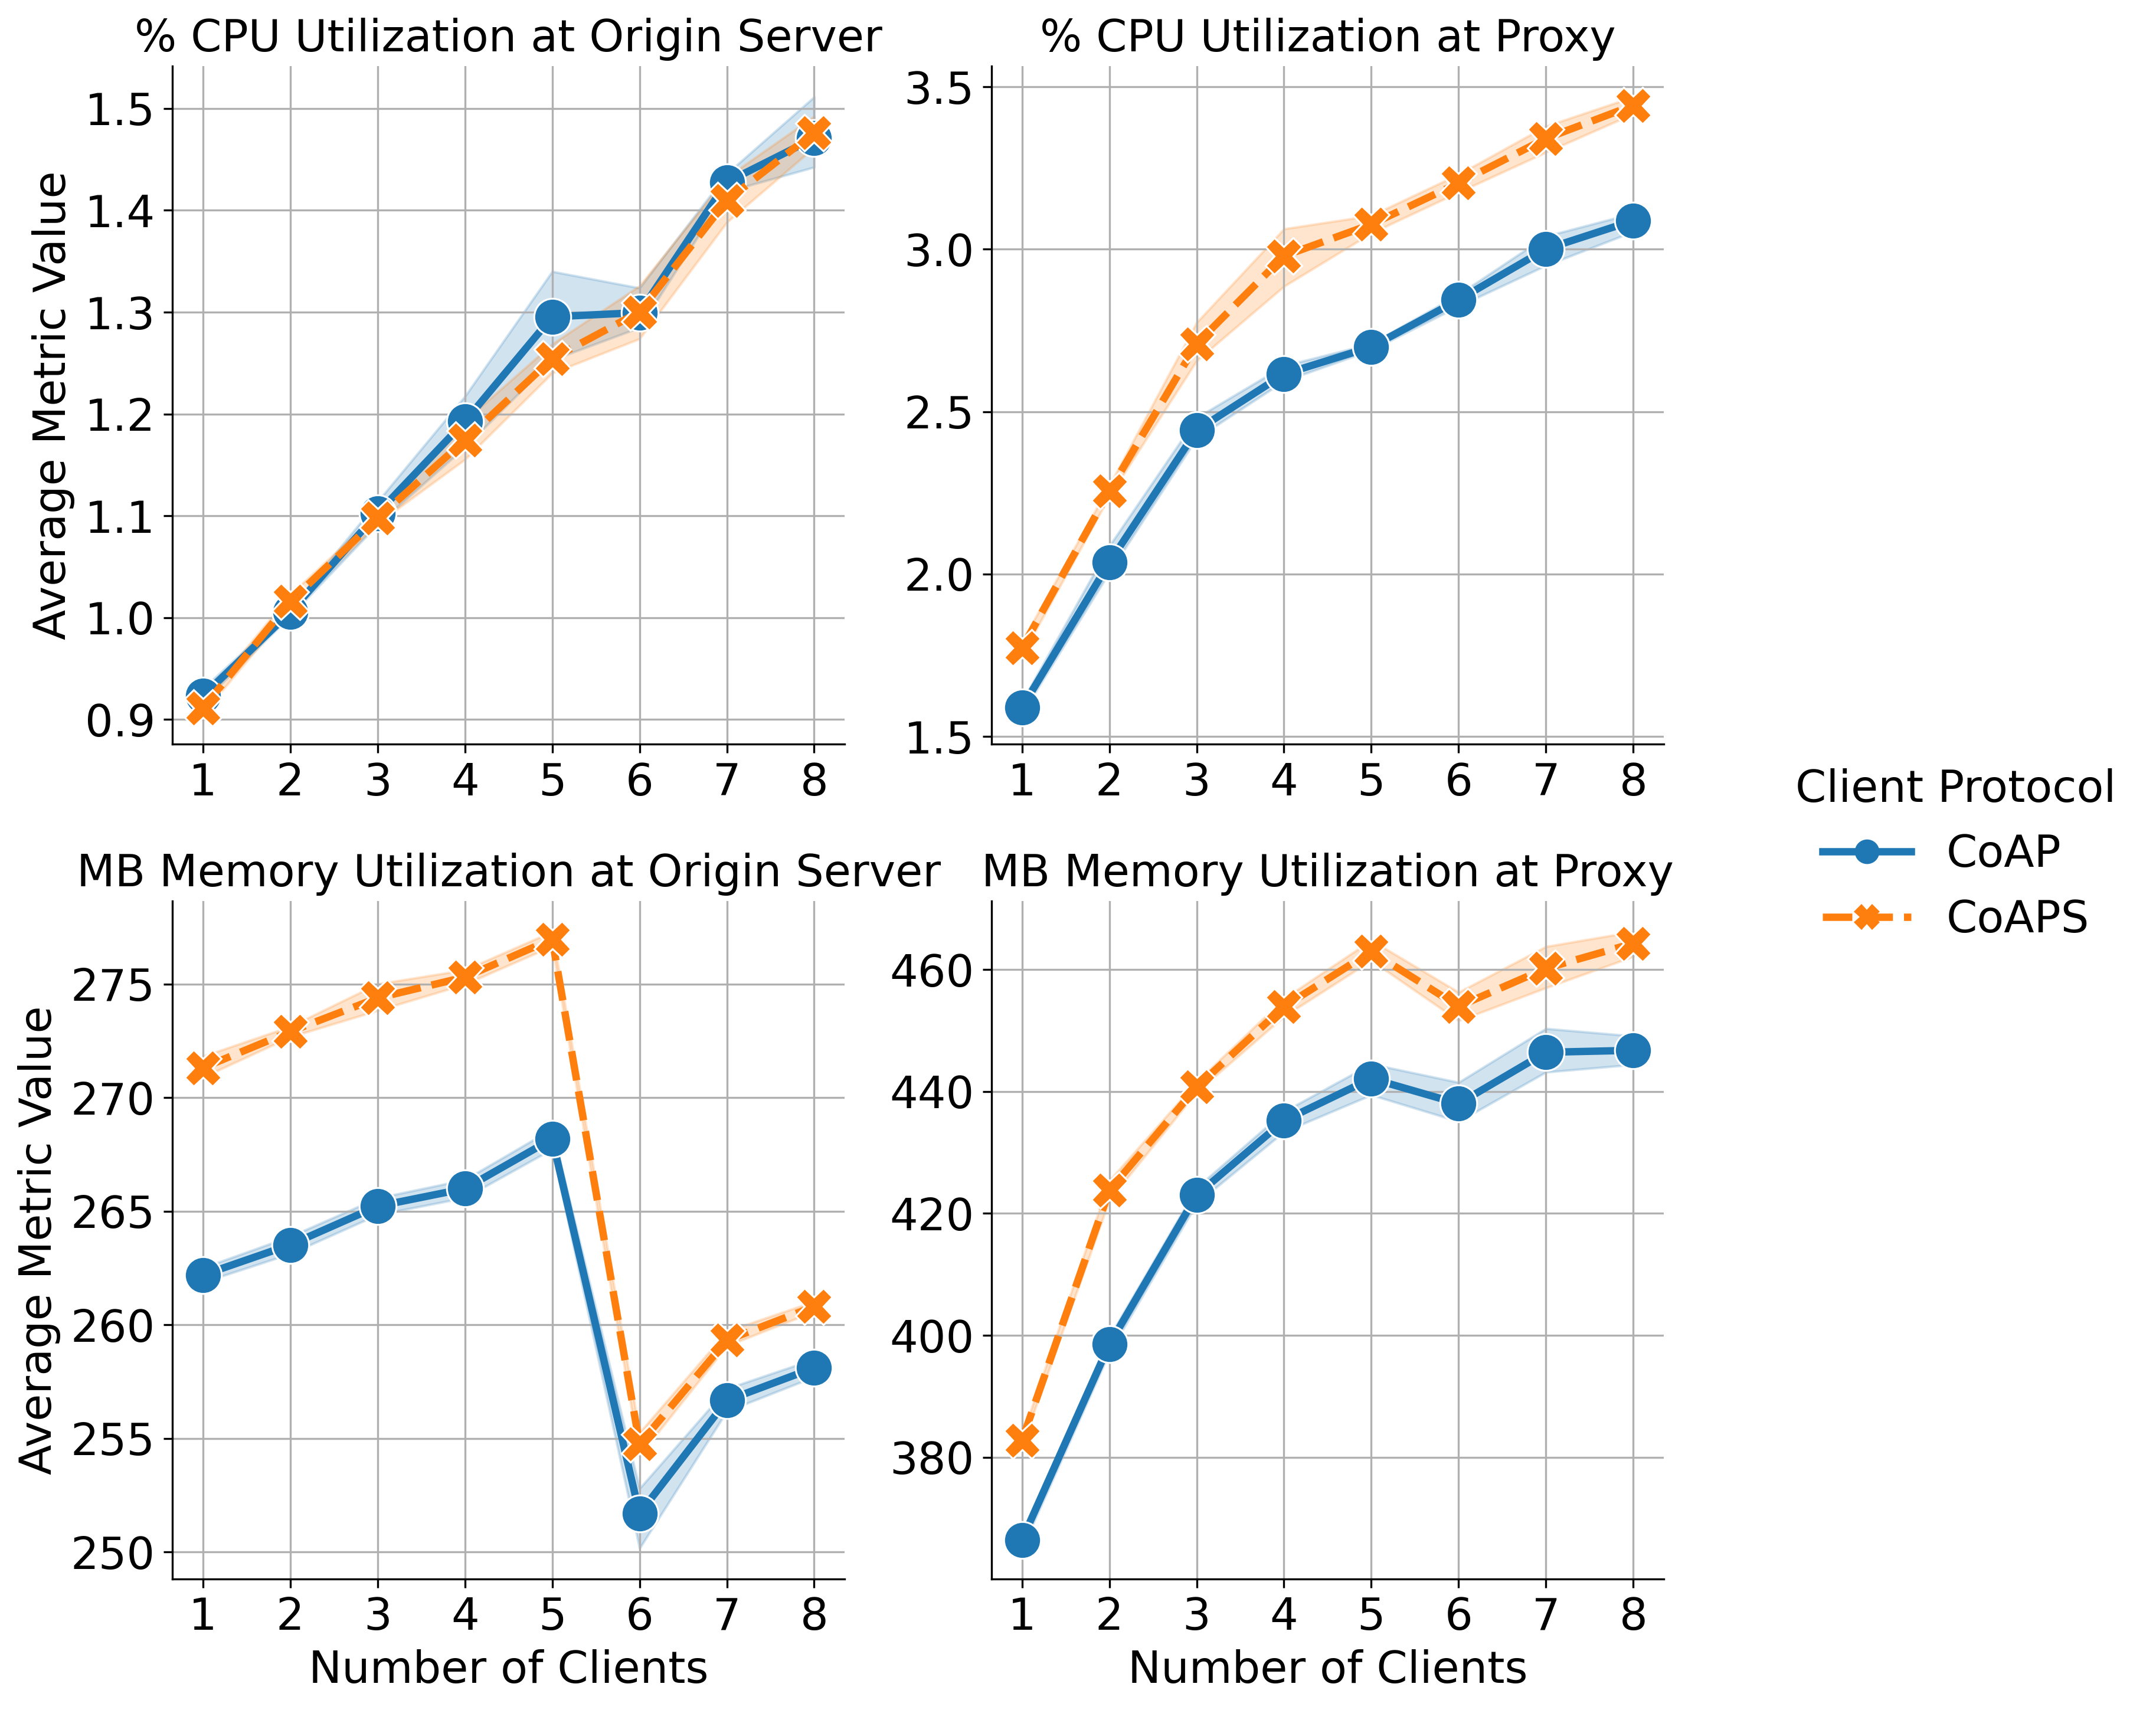

CPU times: user 4.6 s, sys: 512 ms, total: 5.11 s
Wall time: 4.57 s


exp_id  \
0    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                    ...   
315  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
316  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
317  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
318  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
319  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

     trial    observer_id            metric_type   avg_value  min_value  \
0        1  Origin Server      % CPU Utilization    0.935714        0.3   
1        1          Proxy      % CPU Utilization    1.565000        0.5   
2        1  Origin Server  MB Memory Utilization  261.662810      250.0   
3        1          Proxy  MB Memory Utilization  366.561983      251.0   
4        2  Origin Server      % CPU Utilization    0.927143        0.3   
..     ...            ...                    ...         ...        ...   
315      4          Proxy  MB Memory Utilization  462.127273      245.0   
316      5  Origin Server      % CPU Utilization    1.485714        0.4   
317      5          Proxy      % CPU Utilization    3.462143        0.5   
318      5  Origin Server  MB Memory Utilization  260.966997      247.0   
319      5          Proxy  MB Memory Utilization  466.800000      244.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         11.5         0mbps                 256                        0   
1         21.2         0mbps                 256                        0   
2        263.0         0mbps                 256                        0   
3        404.0         0mbps                 256                        0   
4         10.0         0mbps                 256                        0   
..         ...           ...                 ...                      ...   
315      495.0         0mbps                 256                        0   
316        9.2         0mbps                 256                        0   
317       26.5         0mbps                 256                        0   
318      262.0         0mbps                 256                        0   
319      503.0         0mbps                 256                        0   

     ...                             topology_name  num_proxy_connections  \
0    ...  thesis_cloud_proxy_and_internet_attacker                     50   
1    ...  thesis_cloud_proxy_and_internet_attacker                     50   
2    ...  thesis_cloud_proxy_and_internet_attacker                     50   
3    ...  thesis_cloud_proxy_and_internet_attacker                     50   
4    ...  thesis_cloud_proxy_and_internet_attacker                     50   
..   ...                                       ...                    ...   
315  ...  thesis_cloud_proxy_and_internet_attacker                     50   
316  ...  thesis_cloud_proxy_and_internet_attacker                     50   
317  ...  thesis_cloud_proxy_and_internet_attacker                     50   
318  ...  thesis_cloud_proxy_and_internet_attacker                     50   
319  ...  thesis_cloud_proxy_and_internet_attacker                     50   

     request_timeout  max_retries  keep

In [29]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
)

g = sns.relplot(
  data=df,
  kind="line",
  x="num_clients",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": False,
    "sharex": False,
  },
)

g.set_titles(
  template="{row_name} at {col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Number of Clients")
g.set_ylabels("Average Metric Value")
g.legend.set_title("Client Protocol")
g.set(xticks=np.arange(1,9,1))

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
g.axes[1,0].grid(True, axis="both")
g.axes[1,1].grid(True, axis="both")

fig.tight_layout()

plt.show()

df

In [30]:
%%time

## Measure proxy and server connection management.
##
## We currently do not insert connection events to
## the database, so we have to read from the processed
## connection files.

ALL_EXPERIMENTS_DATA_HOME = "/home/ubuntu/dos-californium/deter/expdata/real/final"

def read_exp_trial_node_connections(exp_id):
  """
  Read all processed connection dumps in an experiment `exp_id`.
  """
  experiment_dir = os.path.join(ALL_EXPERIMENTS_DATA_HOME, exp_id)

  # Explore each trial to find connection dumps.
  for trial in sorted(os.listdir(experiment_dir)):
    # Skip metadata directory.
    if trial == "metadata":
      continue

    # Since all trials are directories, skip non-directories.
    trial_dir = os.path.join(experiment_dir, trial)
    if not os.path.isdir(trial_dir):
      continue

    # Explore each file in this directory.
    for file in os.listdir(trial_dir):
      # Only keep processed connection dumps from proxy and server.
      if not (".pcap.connections.out" in file and ("proxy" in file or "server" in file)):
        continue
      connection_dump_path = os.path.join(trial_dir, file)

      # Extract the observing node's name from the file name.
      node_name = file.replace(".pcap.connections.out", "").split("_dump")[0]
      
      # Finally, read in the connection data.
      df = (
        pl
        .scan_csv(
          connection_dump_path,
          sep=";",
          quote_char='"'
        )
        .with_columns([
          pl.lit(int(trial)).alias("trial"),
          pl.lit(exp_id).alias("exp_id"),
          pl.lit(node_name).alias("observer_id"),
        ])
      )
      connection_dfs.append(df)

connection_dfs = list()
for exp_id in exp_df["exp_id"].unique():
  read_exp_trial_node_connections(exp_id)
df = pl.concat(connection_dfs).collect()

# Rename tshark column names for increased readability.
df = (
  df
  .rename({
    "_ws.col.Time"       : "timestamp",
    "_ws.col.Source"     : "src_ip",
    "_ws.col.Destination": "dst_ip",
    "tcp.srcport"        : "src_port",
    "tcp.dstport"        : "dst_port",
    "_ws.col.Length"     : "message_size_bytes",
    "_ws.col.Protocol"   : "protocol",
    "tcp.flags.syn"      : "is_syn",
    "tcp.flags.fin"      : "is_fin",
    "_ws.col.Info"       : "info",
  })
  .sort(by=["exp_id", "trial", "observer_id", "timestamp"])
)

connections_df = (
  # Filter for proxy's view of syn-acks or fin-acks coming from server
  df
  .filter(
    (pl.col("observer_id") == "proxy")
    & ((pl.col("is_syn") == 1) | (pl.col("is_fin") == 1))
    & (pl.col("info").str.contains(", ACK]"))
    & (pl.col("src_port") == 443)
  )
  # Group by experiment, trial, and observer, then accummulate
  # syn-acks and fin-acks in a list, along with their corresponding
  # timestamps of occurrence for each group.
  .groupby(
    by=["exp_id", "trial", "observer_id"],
    maintain_order=True
  )
  .agg([
    pl.col("timestamp").alias("timestamp"),
    pl.col("is_syn").cumsum().alias("cum_syn"),
    pl.col("is_fin").cumsum().alias("cum_fin"),
  ])
  # Explode the cumulative syns and fins, and their times, then
  # subtract them to get a view of how many open connections there
  # are in the experiment as a function of time
  .explode(columns=["timestamp", "cum_syn", "cum_fin"])
  .with_columns([
    (pl.col("cum_syn") - pl.col("cum_fin")).alias("open_connections")
  ])
  # And finally convert to pandas for plotting.
  .to_pandas()
)

# This method of counting does not include the original 0 connections
# at time 0 for each node in each trial -- so we add that manually.
records = list()
for e in connections_df["exp_id"].unique():
  for t in connections_df["trial"].unique():
    for o in connections_df["observer_id"].unique():
      records.append({
        "exp_id"          : e,
        "trial"           : t,
        "observer_id"     : o,
        "timestamp"       : 0.0,
        "cum_syn"         : 0,
        "cum_fin"         : 0,
        "open_connections": 0,
      })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

connections_df = (
  connections_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

connections_df

ShapeError: Could not vertically stack DataFrame. The DataFrames appended width 13 differs from the parent DataFrames width 14

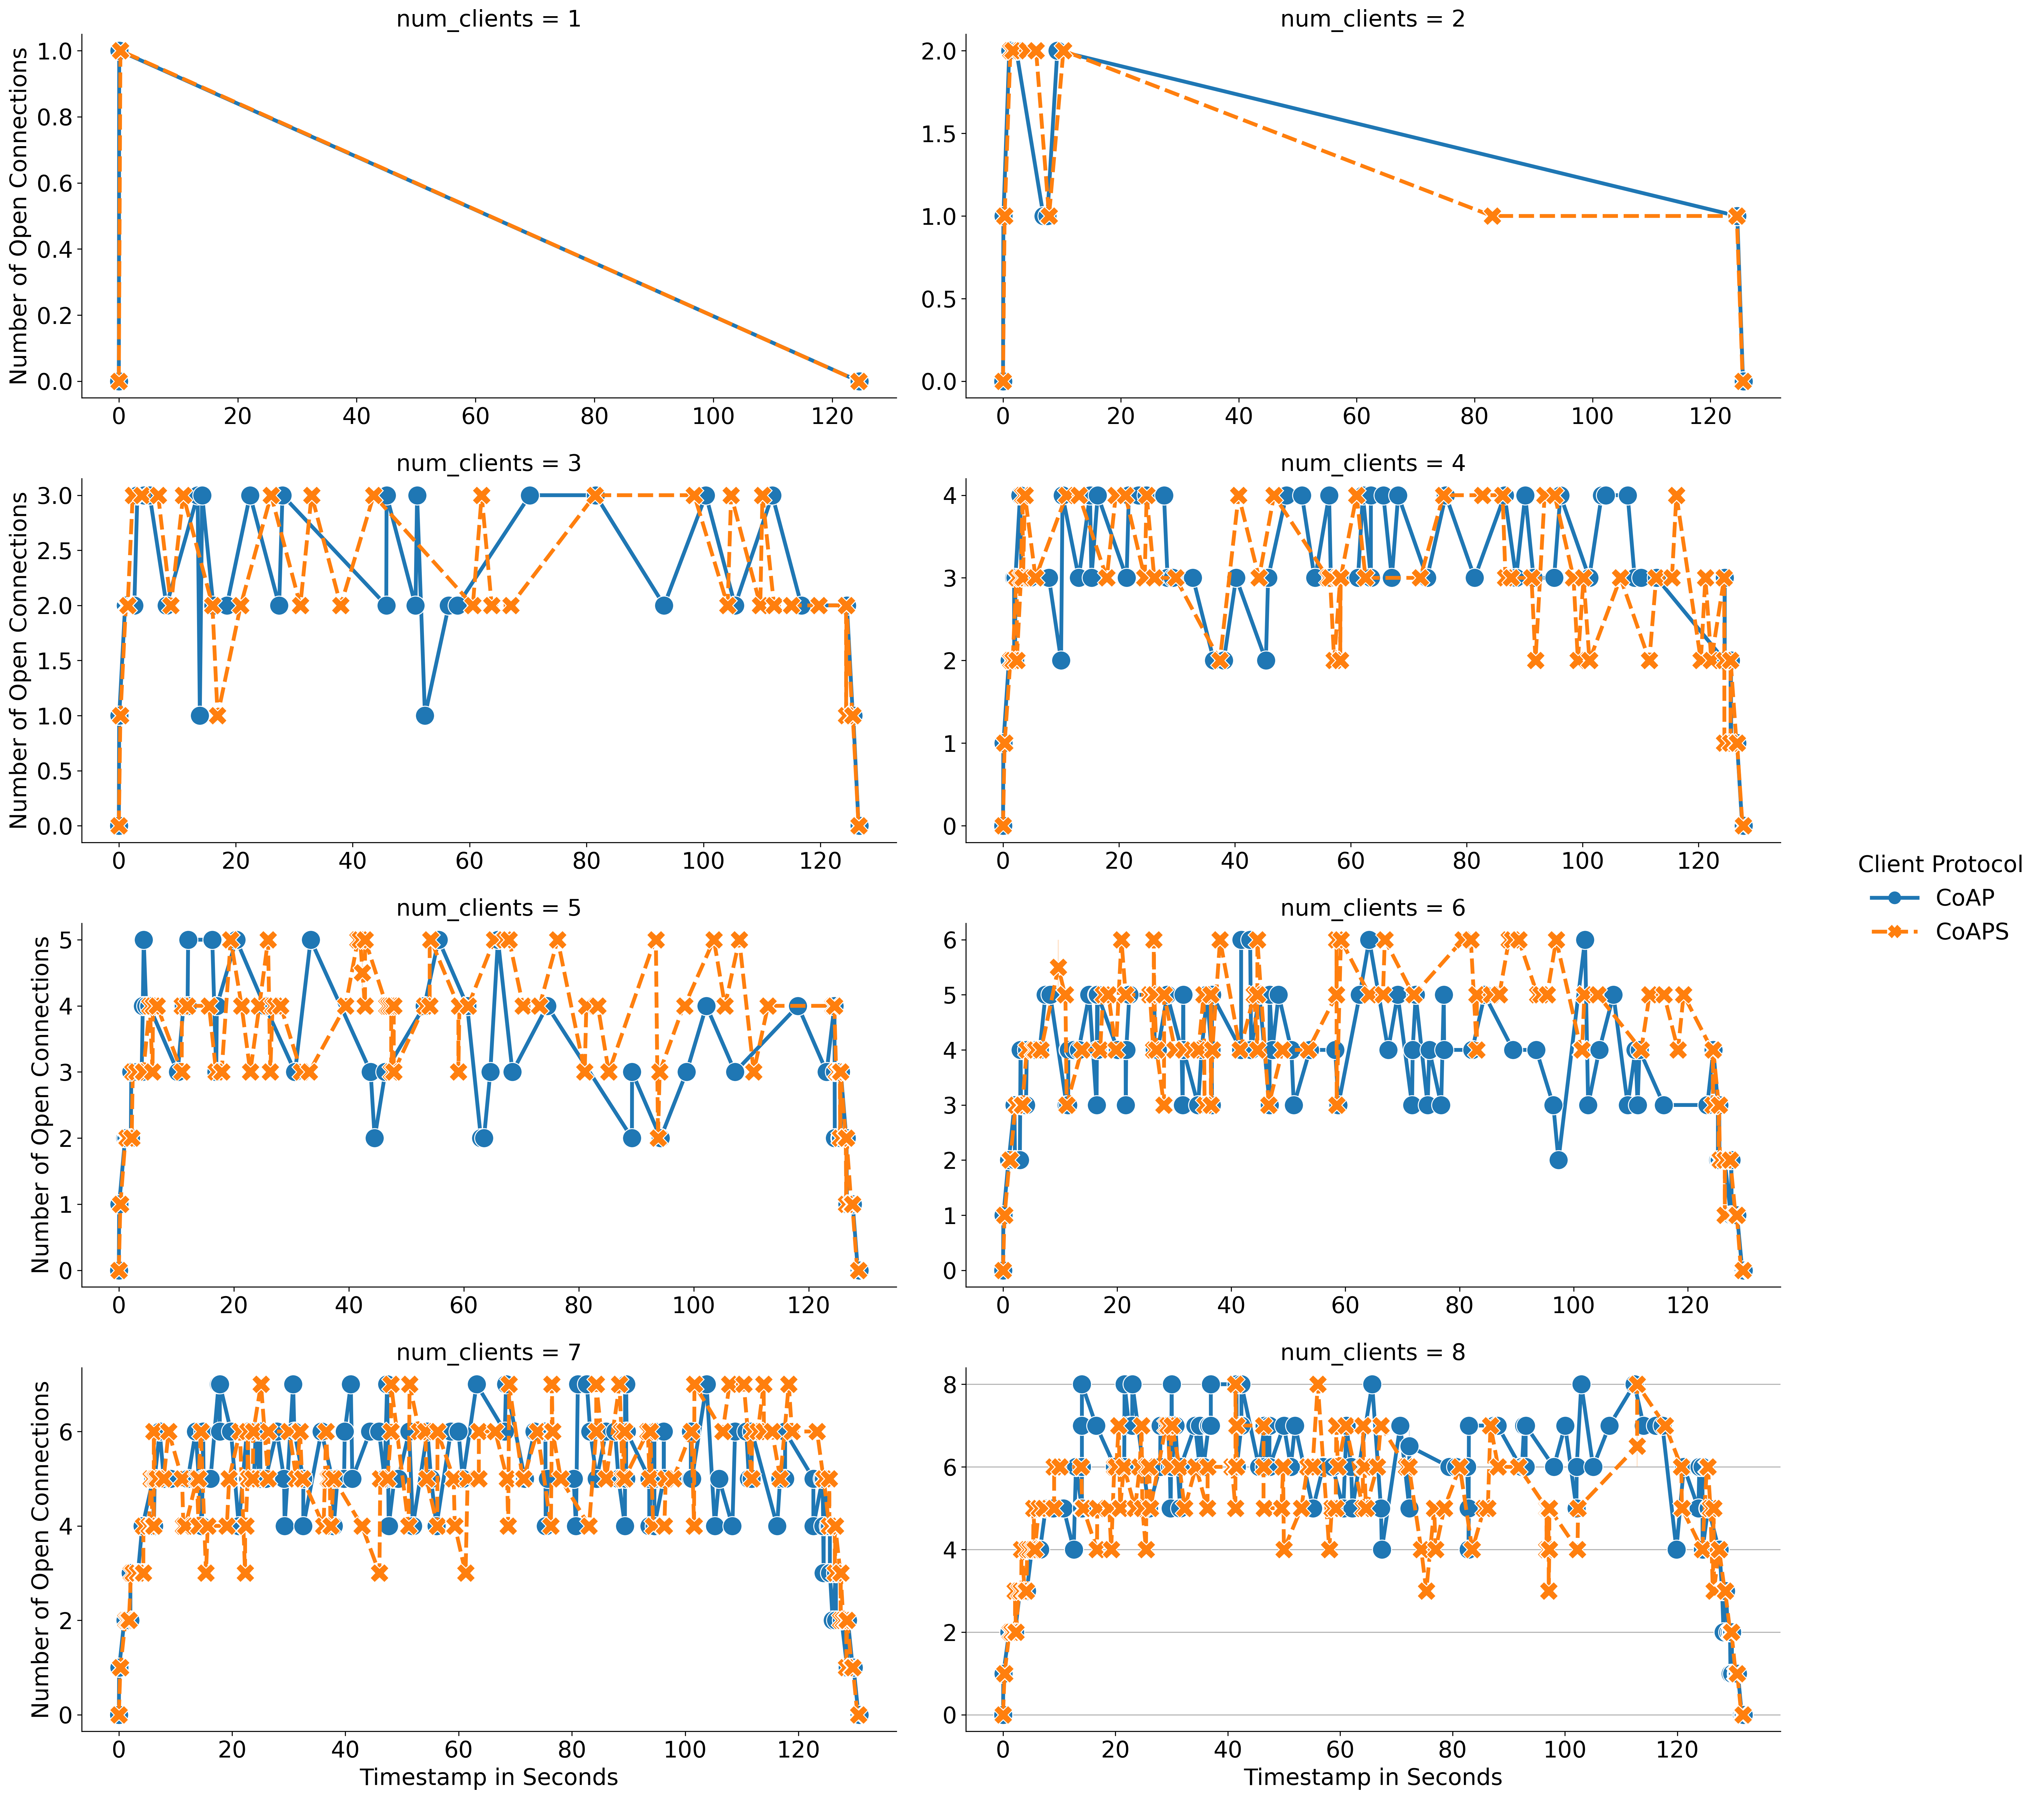

CPU times: user 6.5 s, sys: 926 ms, total: 7.42 s
Wall time: 7.12 s


In [ ]:
%%time

## Measure proxy and server connection management.

df = connections_df

g = sns.relplot(
  data=df,
  kind="line",
  x="timestamp",
  y="open_connections",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  col="num_clients",
  col_wrap=2,
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": False,
    "sharex": False,
  },
  aspect=2,
)
g.set_xlabels("Timestamp in Seconds")
g.set_ylabels("Number of Open Connections")
g.legend.set_title("Client Protocol")

plt.grid(True, axis="y")
plt.show()

In [ ]:
connections_df

exp_id  \
0     thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                    ...   
1387  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1388  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1389  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1390  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1391  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

      trial observer_id   timestamp  cum_syn  cum_fin  open_connections  \
0         1       proxy    0.000000        0        0                 0   
1         1       proxy    0.065862        1        0                 1   
2         1       proxy  124.501115        1        1                 0   
3         2       proxy    0.000000        0        0                 0   
4         2       proxy    0.064202        1        0                 1   
...     ...         ...         ...      ...      ...               ...   
1387      5       proxy  124.415219       13        9                 4   
1388      5       proxy  128.476332       13       10                 3   
1389      5       proxy  129.492474       13       11                 2   
1390      5       proxy  130.518600       13       12                 1   
1391      5       proxy  131.533649       13       13                 0   

     attacker_rate  server_connections  max_keep_alive_requests  ...  \
0            0mbps                 256                        0  ...   
1            0mbps                 256                        0  ...   
2            0mbps                 256                        0  ...   
3            0mbps                 256                        0  ...   
4            0mbps                 256                        0  ...   
...            ...                 ...                      ...  ...   
1387         0mbps                 256                        0  ...   
1388         0mbps                 256                        0  ...   
1389         0mbps                 256                        0  ...   
1390         0mbps                 256                        0  ...   
1391         0mbps                 256                        0  ...   

                                 topology_name  num_proxy_connections  \
0     thesis_cloud_proxy_and_internet_attacker                     50   
1     thesis_cloud_proxy_and_internet_attacker                     50   
2     thesis_cloud_proxy_and_internet_attacker                     50   
3     thesis_cloud_proxy_and_internet_attacker                     50   
4     thesis_cloud_proxy_and_internet_attacker                     50   
...                                        ...                    ...   
1387  thesis_cloud_proxy_and_internet_attacker                     50   
1388  thesis_cloud_proxy_and_internet_attacker                     50   
1389  thesis_cloud_proxy_and_internet_attacker                     50   
1390  thesis_cloud_proxy_and_internet_attacker                     50   
1391  thesis_cloud_proxy_and_internet_attacker                     50   

      request_timeout  max_retries  keep_alive_duration  \
0                   5            2                    5   
1                 

exp_id  \
0   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
4   thesis_group_num_clients_coap_https_1clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                   ...   
75  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
76  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
77  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
78  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
79  thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

    trial observer_id  mean_open_connections run_proxy_with_dtls  num_clients  
0       1       proxy               0.333333                CoAP            1  
1       2       proxy               0.333333                CoAP            1  
2       3       proxy               0.333333                CoAP            1  
3       4       proxy               0.333333                CoAP            1  
4       5       proxy               0.333333                CoAP            1  
..    ...         ...                    ...                 ...          ...  
75      1       proxy               4.612903               CoAPS            8  
76      2       proxy               4.771429               CoAPS            8  
77      3       proxy               4.161290               CoAPS            8  
78      4       proxy               4.185185               CoAPS            8  
79      5       proxy               4.111111               CoAPS            8  

[80 rows x 6 columns]

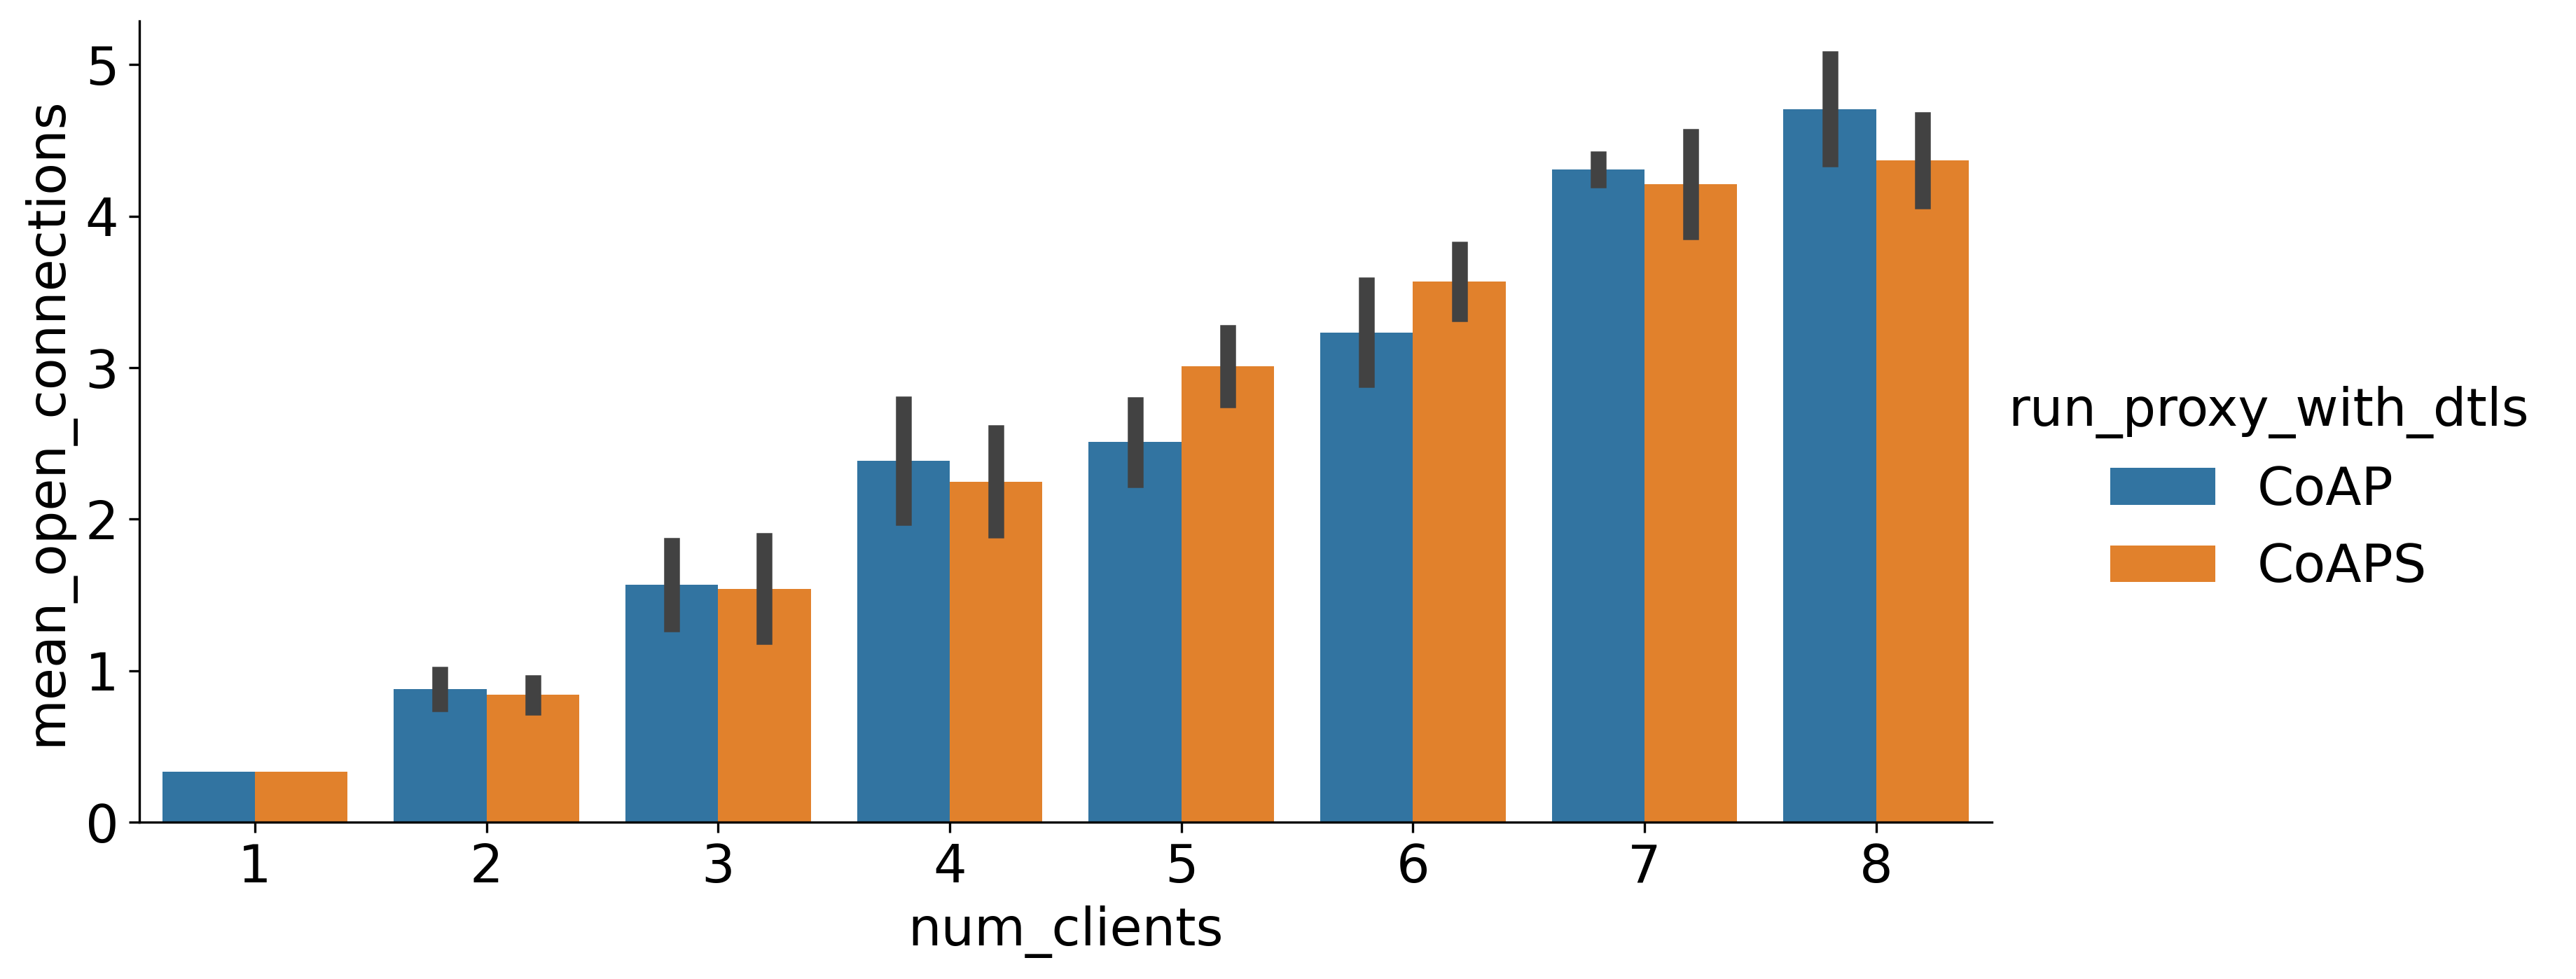

In [ ]:
grouped_connections_df = (
  connections_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .agg(
    mean_open_connections=("open_connections", "mean"),
    run_proxy_with_dtls=("run_proxy_with_dtls", "first"),
    num_clients=("num_clients", "first"),
  )
  .reset_index()
)

g = sns.catplot(
  data=grouped_connections_df,
  kind="bar",
  x="num_clients",
  y="mean_open_connections",
  hue="run_proxy_with_dtls",
  ci="sd",
  aspect=2,
)

grouped_connections_df